In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'exclude'       : ['normalized'],
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100000_2048_1024_512_256_128_0001_CCE_7_1_1_0_1_0_normalized_e_e_0_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_0_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 831)
(3944610, 8)
validation
(464344, 831)
(464344, 8)
test
(574820, 831)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 2048)              1703936   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 4492168 (17.14 MB)


Trainable params: 4492168 (17.14 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/40 [..............................] - ETA: 2:31 - loss: 2.2457 - STD: 0.0692 - MAE: 0.2204

 2/40 [>.............................] - ETA: 16s - loss: 2.1644 - STD: 0.0442 - MAE: 0.2194 

 3/40 [=>............................] - ETA: 16s - loss: 2.1280 - STD: 0.0426 - MAE: 0.2184

 4/40 [==>...........................] - ETA: 16s - loss: 2.1138 - STD: 0.0476 - MAE: 0.2174

 5/40 [==>...........................] - ETA: 15s - loss: 2.1083 - STD: 0.0513 - MAE: 0.2169

 6/40 [===>..........................] - ETA: 15s - loss: 2.1048 - STD: 0.0526 - MAE: 0.2166

 7/40 [====>.........................] - ETA: 14s - loss: 2.1016 - STD: 0.0522 - MAE: 0.2165

 8/40 [=====>........................] - ETA: 14s - loss: 2.0983 - STD: 0.0510 - MAE: 0.2165

 9/40 [=====>........................] - ETA: 13s - loss: 2.0951 - STD: 0.0493 - MAE: 0.2166

10/40 [======>.......................] - ETA: 13s - loss: 2.0917 - STD: 0.0474 - MAE: 0.2166

11/40 [=======>......................] - ETA: 13s - loss: 2.0885 - STD: 0.0457 - MAE: 0.2166

12/40 [========>.....................] - ETA: 12s - loss: 2.0856 - STD: 0.0442 - MAE: 0.2167

13/40 [========>.....................] - ETA: 12s - loss: 2.0831 - STD: 0.0431 - MAE: 0.2167

14/40 [=========>....................] - ETA: 11s - loss: 2.0811 - STD: 0.0423 - MAE: 0.2167

15/40 [==========>...................] - ETA: 11s - loss: 2.0796 - STD: 0.0418 - MAE: 0.2167

16/40 [===========>..................] - ETA: 10s - loss: 2.0783 - STD: 0.0414 - MAE: 0.2167

17/40 [===========>..................] - ETA: 12s - loss: 2.0779 - STD: 0.0410 - MAE: 0.2167

18/40 [============>.................] - ETA: 11s - loss: 2.0767 - STD: 0.0405 - MAE: 0.2167

19/40 [=============>................] - ETA: 10s - loss: 2.0756 - STD: 0.0400 - MAE: 0.2167

20/40 [==============>...............] - ETA: 10s - loss: 2.0745 - STD: 0.0395 - MAE: 0.2167

21/40 [==============>...............] - ETA: 9s - loss: 2.0734 - STD: 0.0389 - MAE: 0.2168 

22/40 [===============>..............] - ETA: 9s - loss: 2.0725 - STD: 0.0384 - MAE: 0.2168

23/40 [================>.............] - ETA: 8s - loss: 2.0716 - STD: 0.0381 - MAE: 0.2168

24/40 [=================>............] - ETA: 8s - loss: 2.0708 - STD: 0.0378 - MAE: 0.2168

25/40 [=================>............] - ETA: 7s - loss: 2.0700 - STD: 0.0376 - MAE: 0.2168

26/40 [==================>...........] - ETA: 6s - loss: 2.0693 - STD: 0.0375 - MAE: 0.2168

27/40 [===================>..........] - ETA: 6s - loss: 2.0687 - STD: 0.0375 - MAE: 0.2167

28/40 [====================>.........] - ETA: 5s - loss: 2.0682 - STD: 0.0375 - MAE: 0.2167

29/40 [====================>.........] - ETA: 5s - loss: 2.0677 - STD: 0.0374 - MAE: 0.2167

30/40 [=====================>........] - ETA: 4s - loss: 2.0672 - STD: 0.0374 - MAE: 0.2167

31/40 [======================>.......] - ETA: 4s - loss: 2.0666 - STD: 0.0374 - MAE: 0.2167

32/40 [=======================>......] - ETA: 3s - loss: 2.0662 - STD: 0.0373 - MAE: 0.2167

33/40 [=======================>......] - ETA: 3s - loss: 2.0657 - STD: 0.0371 - MAE: 0.2167

34/40 [========================>.....] - ETA: 2s - loss: 2.0653 - STD: 0.0370 - MAE: 0.2167

35/40 [=========================>....] - ETA: 2s - loss: 2.0649 - STD: 0.0368 - MAE: 0.2167

36/40 [==========================>...] - ETA: 1s - loss: 2.0645 - STD: 0.0366 - MAE: 0.2167

37/40 [==========================>...] - ETA: 1s - loss: 2.0641 - STD: 0.0365 - MAE: 0.2167

38/40 [===========================>..] - ETA: 0s - loss: 2.0637 - STD: 0.0363 - MAE: 0.2167

39/40 [============================>.] - ETA: 0s - loss: 2.0634 - STD: 0.0361 - MAE: 0.2167

40/40 [==============================] - ETA: 0s - loss: 2.0631 - STD: 0.0360 - MAE: 0.2167

40/40 [==============================] - 25s 535ms/step - loss: 2.0631 - STD: 0.0360 - MAE: 0.2167 - val_loss: 2.0495 - val_STD: 0.0314 - val_MAE: 0.2167


Epoch 2/10000


 1/40 [..............................] - ETA: 24s - loss: 2.0495 - STD: 0.0314 - MAE: 0.2167

 2/40 [>.............................] - ETA: 17s - loss: 2.0495 - STD: 0.0315 - MAE: 0.2167

 3/40 [=>............................] - ETA: 16s - loss: 2.0494 - STD: 0.0316 - MAE: 0.2167

 4/40 [==>...........................] - ETA: 16s - loss: 2.0493 - STD: 0.0317 - MAE: 0.2167

 5/40 [==>...........................] - ETA: 15s - loss: 2.0487 - STD: 0.0317 - MAE: 0.2166

 6/40 [===>..........................] - ETA: 15s - loss: 2.0486 - STD: 0.0318 - MAE: 0.2166

 7/40 [====>.........................] - ETA: 15s - loss: 2.0481 - STD: 0.0319 - MAE: 0.2166

 8/40 [=====>........................] - ETA: 14s - loss: 2.0478 - STD: 0.0321 - MAE: 0.2166

 9/40 [=====>........................] - ETA: 14s - loss: 2.0474 - STD: 0.0322 - MAE: 0.2166

10/40 [======>.......................] - ETA: 13s - loss: 2.0471 - STD: 0.0324 - MAE: 0.2165

11/40 [=======>......................] - ETA: 13s - loss: 2.0467 - STD: 0.0325 - MAE: 0.2165

12/40 [========>.....................] - ETA: 12s - loss: 2.0460 - STD: 0.0326 - MAE: 0.2165

13/40 [========>.....................] - ETA: 12s - loss: 2.0452 - STD: 0.0325 - MAE: 0.2165

14/40 [=========>....................] - ETA: 11s - loss: 2.0442 - STD: 0.0325 - MAE: 0.2165

15/40 [==========>...................] - ETA: 11s - loss: 2.0431 - STD: 0.0324 - MAE: 0.2164

16/40 [===========>..................] - ETA: 10s - loss: 2.0419 - STD: 0.0323 - MAE: 0.2164

17/40 [===========>..................] - ETA: 10s - loss: 2.0403 - STD: 0.0322 - MAE: 0.2163

18/40 [============>.................] - ETA: 10s - loss: 2.0384 - STD: 0.0323 - MAE: 0.2163

19/40 [=============>................] - ETA: 9s - loss: 2.0363 - STD: 0.0324 - MAE: 0.2162 

20/40 [==============>...............] - ETA: 9s - loss: 2.0340 - STD: 0.0325 - MAE: 0.2161

21/40 [==============>...............] - ETA: 8s - loss: 2.0314 - STD: 0.0328 - MAE: 0.2160

22/40 [===============>..............] - ETA: 8s - loss: 2.0286 - STD: 0.0331 - MAE: 0.2159

23/40 [================>.............] - ETA: 7s - loss: 2.0254 - STD: 0.0336 - MAE: 0.2158

24/40 [=================>............] - ETA: 7s - loss: 2.0219 - STD: 0.0341 - MAE: 0.2156

25/40 [=================>............] - ETA: 6s - loss: 2.0182 - STD: 0.0347 - MAE: 0.2155

26/40 [==================>...........] - ETA: 6s - loss: 2.0144 - STD: 0.0354 - MAE: 0.2153

27/40 [===================>..........] - ETA: 5s - loss: 2.0105 - STD: 0.0361 - MAE: 0.2151

28/40 [====================>.........] - ETA: 5s - loss: 2.0064 - STD: 0.0370 - MAE: 0.2149

29/40 [====================>.........] - ETA: 5s - loss: 2.0021 - STD: 0.0379 - MAE: 0.2147

30/40 [=====================>........] - ETA: 4s - loss: 1.9979 - STD: 0.0388 - MAE: 0.2145

31/40 [======================>.......] - ETA: 4s - loss: 1.9936 - STD: 0.0398 - MAE: 0.2143

32/40 [=======================>......] - ETA: 3s - loss: 1.9893 - STD: 0.0406 - MAE: 0.2141

33/40 [=======================>......] - ETA: 3s - loss: 1.9849 - STD: 0.0415 - MAE: 0.2138

34/40 [========================>.....] - ETA: 2s - loss: 1.9805 - STD: 0.0423 - MAE: 0.2136

35/40 [=========================>....] - ETA: 2s - loss: 1.9759 - STD: 0.0432 - MAE: 0.2134

36/40 [==========================>...] - ETA: 1s - loss: 1.9716 - STD: 0.0441 - MAE: 0.2132

37/40 [==========================>...] - ETA: 1s - loss: 1.9678 - STD: 0.0450 - MAE: 0.2129

38/40 [===========================>..] - ETA: 0s - loss: 1.9640 - STD: 0.0460 - MAE: 0.2127

39/40 [============================>.] - ETA: 0s - loss: 1.9621 - STD: 0.0469 - MAE: 0.2125

40/40 [==============================] - ETA: 0s - loss: 1.9583 - STD: 0.0477 - MAE: 0.2123

40/40 [==============================] - 19s 472ms/step - loss: 1.9583 - STD: 0.0477 - MAE: 0.2123 - val_loss: 1.7321 - val_STD: 0.0771 - val_MAE: 0.2023


Epoch 3/10000


 1/40 [..............................] - ETA: 24s - loss: 1.7948 - STD: 0.0833 - MAE: 0.2032

 2/40 [>.............................] - ETA: 17s - loss: 1.7914 - STD: 0.0838 - MAE: 0.2031

 3/40 [=>............................] - ETA: 16s - loss: 1.7915 - STD: 0.0835 - MAE: 0.2031

 4/40 [==>...........................] - ETA: 16s - loss: 1.7861 - STD: 0.0839 - MAE: 0.2029

 5/40 [==>...........................] - ETA: 15s - loss: 1.7854 - STD: 0.0852 - MAE: 0.2026

 6/40 [===>..........................] - ETA: 15s - loss: 1.7814 - STD: 0.0856 - MAE: 0.2024

 7/40 [====>.........................] - ETA: 15s - loss: 1.7801 - STD: 0.0858 - MAE: 0.2024

 8/40 [=====>........................] - ETA: 14s - loss: 1.7771 - STD: 0.0862 - MAE: 0.2022

 9/40 [=====>........................] - ETA: 14s - loss: 1.7751 - STD: 0.0867 - MAE: 0.2021

10/40 [======>.......................] - ETA: 13s - loss: 1.7731 - STD: 0.0870 - MAE: 0.2019

11/40 [=======>......................] - ETA: 13s - loss: 1.7707 - STD: 0.0875 - MAE: 0.2018

12/40 [========>.....................] - ETA: 12s - loss: 1.7689 - STD: 0.0882 - MAE: 0.2016

13/40 [========>.....................] - ETA: 12s - loss: 1.7666 - STD: 0.0886 - MAE: 0.2015

14/40 [=========>....................] - ETA: 11s - loss: 1.7650 - STD: 0.0889 - MAE: 0.2013

15/40 [==========>...................] - ETA: 11s - loss: 1.7626 - STD: 0.0892 - MAE: 0.2012

16/40 [===========>..................] - ETA: 10s - loss: 1.7607 - STD: 0.0896 - MAE: 0.2011

17/40 [===========>..................] - ETA: 10s - loss: 1.7589 - STD: 0.0900 - MAE: 0.2009

18/40 [============>.................] - ETA: 10s - loss: 1.7569 - STD: 0.0904 - MAE: 0.2008

19/40 [=============>................] - ETA: 9s - loss: 1.7551 - STD: 0.0907 - MAE: 0.2007 

20/40 [==============>...............] - ETA: 9s - loss: 1.7531 - STD: 0.0910 - MAE: 0.2006

21/40 [==============>...............] - ETA: 8s - loss: 1.7511 - STD: 0.0913 - MAE: 0.2005

22/40 [===============>..............] - ETA: 8s - loss: 1.7493 - STD: 0.0917 - MAE: 0.2003

23/40 [================>.............] - ETA: 7s - loss: 1.7473 - STD: 0.0920 - MAE: 0.2002

24/40 [=================>............] - ETA: 7s - loss: 1.7453 - STD: 0.0923 - MAE: 0.2001

25/40 [=================>............] - ETA: 6s - loss: 1.7445 - STD: 0.0926 - MAE: 0.2000

26/40 [==================>...........] - ETA: 6s - loss: 1.7424 - STD: 0.0929 - MAE: 0.1998

27/40 [===================>..........] - ETA: 5s - loss: 1.7401 - STD: 0.0932 - MAE: 0.1997

28/40 [====================>.........] - ETA: 5s - loss: 1.7380 - STD: 0.0935 - MAE: 0.1996

29/40 [====================>.........] - ETA: 4s - loss: 1.7359 - STD: 0.0938 - MAE: 0.1994

30/40 [=====================>........] - ETA: 4s - loss: 1.7340 - STD: 0.0941 - MAE: 0.1993

31/40 [======================>.......] - ETA: 4s - loss: 1.7317 - STD: 0.0944 - MAE: 0.1992

32/40 [=======================>......] - ETA: 3s - loss: 1.7293 - STD: 0.0947 - MAE: 0.1990

33/40 [=======================>......] - ETA: 3s - loss: 1.7266 - STD: 0.0950 - MAE: 0.1989

34/40 [========================>.....] - ETA: 2s - loss: 1.7241 - STD: 0.0953 - MAE: 0.1987

35/40 [=========================>....] - ETA: 2s - loss: 1.7213 - STD: 0.0956 - MAE: 0.1986

36/40 [==========================>...] - ETA: 1s - loss: 1.7186 - STD: 0.0959 - MAE: 0.1984

37/40 [==========================>...] - ETA: 1s - loss: 1.7162 - STD: 0.0963 - MAE: 0.1982

38/40 [===========================>..] - ETA: 0s - loss: 1.7139 - STD: 0.0966 - MAE: 0.1981

39/40 [============================>.] - ETA: 0s - loss: 1.7111 - STD: 0.0969 - MAE: 0.1979

40/40 [==============================] - ETA: 0s - loss: 1.7077 - STD: 0.0973 - MAE: 0.1977

40/40 [==============================] - 19s 473ms/step - loss: 1.7077 - STD: 0.0973 - MAE: 0.1977 - val_loss: 1.5339 - val_STD: 0.1069 - val_MAE: 0.1887


Epoch 4/10000


 1/40 [..............................] - ETA: 24s - loss: 1.5795 - STD: 0.1141 - MAE: 0.1893

 2/40 [>.............................] - ETA: 17s - loss: 1.5809 - STD: 0.1140 - MAE: 0.1892

 3/40 [=>............................] - ETA: 16s - loss: 1.5712 - STD: 0.1149 - MAE: 0.1887

 4/40 [==>...........................] - ETA: 16s - loss: 1.5625 - STD: 0.1160 - MAE: 0.1882

 5/40 [==>...........................] - ETA: 15s - loss: 1.5592 - STD: 0.1169 - MAE: 0.1878

 6/40 [===>..........................] - ETA: 15s - loss: 1.5546 - STD: 0.1178 - MAE: 0.1875

 7/40 [====>.........................] - ETA: 15s - loss: 1.5481 - STD: 0.1187 - MAE: 0.1870

 8/40 [=====>........................] - ETA: 14s - loss: 1.5436 - STD: 0.1195 - MAE: 0.1867

 9/40 [=====>........................] - ETA: 14s - loss: 1.5405 - STD: 0.1203 - MAE: 0.1863

10/40 [======>.......................] - ETA: 13s - loss: 1.5361 - STD: 0.1211 - MAE: 0.1860

11/40 [=======>......................] - ETA: 13s - loss: 1.5313 - STD: 0.1220 - MAE: 0.1856

12/40 [========>.....................] - ETA: 12s - loss: 1.5272 - STD: 0.1227 - MAE: 0.1853

13/40 [========>.....................] - ETA: 11s - loss: 1.5255 - STD: 0.1235 - MAE: 0.1850

14/40 [=========>....................] - ETA: 11s - loss: 1.5236 - STD: 0.1243 - MAE: 0.1847

15/40 [==========>...................] - ETA: 10s - loss: 1.5204 - STD: 0.1249 - MAE: 0.1844

16/40 [===========>..................] - ETA: 10s - loss: 1.5165 - STD: 0.1255 - MAE: 0.1842

17/40 [===========>..................] - ETA: 10s - loss: 1.5133 - STD: 0.1262 - MAE: 0.1839

18/40 [============>.................] - ETA: 9s - loss: 1.5100 - STD: 0.1267 - MAE: 0.1836 

19/40 [=============>................] - ETA: 9s - loss: 1.5071 - STD: 0.1271 - MAE: 0.1834

20/40 [==============>...............] - ETA: 8s - loss: 1.5047 - STD: 0.1277 - MAE: 0.1832

21/40 [==============>...............] - ETA: 8s - loss: 1.5025 - STD: 0.1282 - MAE: 0.1830

22/40 [===============>..............] - ETA: 7s - loss: 1.5007 - STD: 0.1286 - MAE: 0.1828

23/40 [================>.............] - ETA: 7s - loss: 1.4988 - STD: 0.1291 - MAE: 0.1826

24/40 [=================>............] - ETA: 7s - loss: 1.4963 - STD: 0.1295 - MAE: 0.1824

25/40 [=================>............] - ETA: 6s - loss: 1.4942 - STD: 0.1299 - MAE: 0.1823

26/40 [==================>...........] - ETA: 6s - loss: 1.4919 - STD: 0.1303 - MAE: 0.1821

27/40 [===================>..........] - ETA: 5s - loss: 1.4902 - STD: 0.1307 - MAE: 0.1819

28/40 [====================>.........] - ETA: 5s - loss: 1.4889 - STD: 0.1309 - MAE: 0.1818

29/40 [====================>.........] - ETA: 4s - loss: 1.4868 - STD: 0.1312 - MAE: 0.1816

30/40 [=====================>........] - ETA: 4s - loss: 1.4850 - STD: 0.1315 - MAE: 0.1815

31/40 [======================>.......] - ETA: 4s - loss: 1.4833 - STD: 0.1318 - MAE: 0.1814

32/40 [=======================>......] - ETA: 3s - loss: 1.4821 - STD: 0.1320 - MAE: 0.1812

33/40 [=======================>......] - ETA: 3s - loss: 1.4804 - STD: 0.1324 - MAE: 0.1811

34/40 [========================>.....] - ETA: 2s - loss: 1.4784 - STD: 0.1327 - MAE: 0.1809

35/40 [=========================>....] - ETA: 2s - loss: 1.4770 - STD: 0.1329 - MAE: 0.1808

36/40 [==========================>...] - ETA: 1s - loss: 1.4753 - STD: 0.1331 - MAE: 0.1807

37/40 [==========================>...] - ETA: 1s - loss: 1.4738 - STD: 0.1334 - MAE: 0.1805

38/40 [===========================>..] - ETA: 0s - loss: 1.4719 - STD: 0.1336 - MAE: 0.1804

39/40 [============================>.] - ETA: 0s - loss: 1.4703 - STD: 0.1338 - MAE: 0.1803

40/40 [==============================] - ETA: 0s - loss: 1.4688 - STD: 0.1340 - MAE: 0.1802

40/40 [==============================] - 19s 473ms/step - loss: 1.4688 - STD: 0.1340 - MAE: 0.1802 - val_loss: 1.3689 - val_STD: 0.1398 - val_MAE: 0.1743


Epoch 5/10000


 1/40 [..............................] - ETA: 24s - loss: 1.4019 - STD: 0.1433 - MAE: 0.1749

 2/40 [>.............................] - ETA: 17s - loss: 1.4034 - STD: 0.1434 - MAE: 0.1749

 3/40 [=>............................] - ETA: 16s - loss: 1.4008 - STD: 0.1438 - MAE: 0.1747

 4/40 [==>...........................] - ETA: 16s - loss: 1.3996 - STD: 0.1444 - MAE: 0.1745

 5/40 [==>...........................] - ETA: 16s - loss: 1.3974 - STD: 0.1445 - MAE: 0.1744

 6/40 [===>..........................] - ETA: 15s - loss: 1.3961 - STD: 0.1445 - MAE: 0.1743

 7/40 [====>.........................] - ETA: 15s - loss: 1.3943 - STD: 0.1447 - MAE: 0.1742

 8/40 [=====>........................] - ETA: 14s - loss: 1.3936 - STD: 0.1449 - MAE: 0.1741

 9/40 [=====>........................] - ETA: 14s - loss: 1.3940 - STD: 0.1449 - MAE: 0.1741

10/40 [======>.......................] - ETA: 13s - loss: 1.3944 - STD: 0.1453 - MAE: 0.1740

11/40 [=======>......................] - ETA: 13s - loss: 1.3974 - STD: 0.1454 - MAE: 0.1741

12/40 [========>.....................] - ETA: 12s - loss: 1.4014 - STD: 0.1458 - MAE: 0.1741

13/40 [========>.....................] - ETA: 12s - loss: 1.4028 - STD: 0.1458 - MAE: 0.1742

14/40 [=========>....................] - ETA: 11s - loss: 1.4009 - STD: 0.1460 - MAE: 0.1740

15/40 [==========>...................] - ETA: 11s - loss: 1.4003 - STD: 0.1462 - MAE: 0.1740

16/40 [===========>..................] - ETA: 11s - loss: 1.4006 - STD: 0.1462 - MAE: 0.1739

17/40 [===========>..................] - ETA: 10s - loss: 1.3993 - STD: 0.1464 - MAE: 0.1738

18/40 [============>.................] - ETA: 10s - loss: 1.3976 - STD: 0.1466 - MAE: 0.1737

19/40 [=============>................] - ETA: 9s - loss: 1.3972 - STD: 0.1467 - MAE: 0.1736 

20/40 [==============>...............] - ETA: 9s - loss: 1.3961 - STD: 0.1468 - MAE: 0.1736

21/40 [==============>...............] - ETA: 8s - loss: 1.3945 - STD: 0.1469 - MAE: 0.1735

22/40 [===============>..............] - ETA: 8s - loss: 1.3937 - STD: 0.1469 - MAE: 0.1734

23/40 [================>.............] - ETA: 7s - loss: 1.3927 - STD: 0.1471 - MAE: 0.1733

24/40 [=================>............] - ETA: 7s - loss: 1.3912 - STD: 0.1472 - MAE: 0.1732

25/40 [=================>............] - ETA: 6s - loss: 1.3900 - STD: 0.1473 - MAE: 0.1731

26/40 [==================>...........] - ETA: 6s - loss: 1.3893 - STD: 0.1474 - MAE: 0.1730

27/40 [===================>..........] - ETA: 5s - loss: 1.3880 - STD: 0.1476 - MAE: 0.1730

28/40 [====================>.........] - ETA: 5s - loss: 1.3869 - STD: 0.1477 - MAE: 0.1729

29/40 [====================>.........] - ETA: 5s - loss: 1.3857 - STD: 0.1478 - MAE: 0.1728

30/40 [=====================>........] - ETA: 4s - loss: 1.3852 - STD: 0.1479 - MAE: 0.1727

31/40 [======================>.......] - ETA: 4s - loss: 1.3839 - STD: 0.1480 - MAE: 0.1726

32/40 [=======================>......] - ETA: 3s - loss: 1.3827 - STD: 0.1481 - MAE: 0.1725

33/40 [=======================>......] - ETA: 3s - loss: 1.3816 - STD: 0.1482 - MAE: 0.1724

34/40 [========================>.....] - ETA: 2s - loss: 1.3804 - STD: 0.1483 - MAE: 0.1723

35/40 [=========================>....] - ETA: 2s - loss: 1.3794 - STD: 0.1485 - MAE: 0.1722

36/40 [==========================>...] - ETA: 1s - loss: 1.3784 - STD: 0.1486 - MAE: 0.1722

37/40 [==========================>...] - ETA: 1s - loss: 1.3774 - STD: 0.1487 - MAE: 0.1721

38/40 [===========================>..] - ETA: 0s - loss: 1.3762 - STD: 0.1488 - MAE: 0.1720

39/40 [============================>.] - ETA: 0s - loss: 1.3752 - STD: 0.1489 - MAE: 0.1719

40/40 [==============================] - ETA: 0s - loss: 1.3740 - STD: 0.1491 - MAE: 0.1718

40/40 [==============================] - 19s 474ms/step - loss: 1.3740 - STD: 0.1491 - MAE: 0.1718 - val_loss: 1.3172 - val_STD: 0.1530 - val_MAE: 0.1678


Epoch 6/10000


 1/40 [..............................] - ETA: 24s - loss: 1.3268 - STD: 0.1543 - MAE: 0.1680

 2/40 [>.............................] - ETA: 17s - loss: 1.3255 - STD: 0.1542 - MAE: 0.1678

 3/40 [=>............................] - ETA: 16s - loss: 1.3252 - STD: 0.1544 - MAE: 0.1678

 4/40 [==>...........................] - ETA: 16s - loss: 1.3252 - STD: 0.1545 - MAE: 0.1677

 5/40 [==>...........................] - ETA: 15s - loss: 1.3249 - STD: 0.1548 - MAE: 0.1676

 6/40 [===>..........................] - ETA: 15s - loss: 1.3265 - STD: 0.1550 - MAE: 0.1676

 7/40 [====>.........................] - ETA: 15s - loss: 1.3375 - STD: 0.1555 - MAE: 0.1680

 8/40 [=====>........................] - ETA: 14s - loss: 1.3657 - STD: 0.1558 - MAE: 0.1689

 9/40 [=====>........................] - ETA: 14s - loss: 1.3807 - STD: 0.1562 - MAE: 0.1694

10/40 [======>.......................] - ETA: 13s - loss: 1.3760 - STD: 0.1563 - MAE: 0.1692

11/40 [=======>......................] - ETA: 13s - loss: 1.3845 - STD: 0.1563 - MAE: 0.1695

12/40 [========>.....................] - ETA: 12s - loss: 1.3837 - STD: 0.1563 - MAE: 0.1695

13/40 [========>.....................] - ETA: 12s - loss: 1.3846 - STD: 0.1567 - MAE: 0.1694

14/40 [=========>....................] - ETA: 11s - loss: 1.3854 - STD: 0.1568 - MAE: 0.1694

15/40 [==========>...................] - ETA: 11s - loss: 1.3836 - STD: 0.1567 - MAE: 0.1693

16/40 [===========>..................] - ETA: 10s - loss: 1.3835 - STD: 0.1567 - MAE: 0.1694

17/40 [===========>..................] - ETA: 10s - loss: 1.3816 - STD: 0.1568 - MAE: 0.1692

18/40 [============>.................] - ETA: 10s - loss: 1.3805 - STD: 0.1568 - MAE: 0.1692

19/40 [=============>................] - ETA: 9s - loss: 1.3789 - STD: 0.1565 - MAE: 0.1692 

20/40 [==============>...............] - ETA: 9s - loss: 1.3771 - STD: 0.1564 - MAE: 0.1692

21/40 [==============>...............] - ETA: 8s - loss: 1.3755 - STD: 0.1565 - MAE: 0.1691

22/40 [===============>..............] - ETA: 8s - loss: 1.3734 - STD: 0.1565 - MAE: 0.1690

23/40 [================>.............] - ETA: 7s - loss: 1.3717 - STD: 0.1564 - MAE: 0.1689

24/40 [=================>............] - ETA: 7s - loss: 1.3700 - STD: 0.1563 - MAE: 0.1689

25/40 [=================>............] - ETA: 6s - loss: 1.3684 - STD: 0.1564 - MAE: 0.1688

26/40 [==================>...........] - ETA: 6s - loss: 1.3665 - STD: 0.1564 - MAE: 0.1687

27/40 [===================>..........] - ETA: 5s - loss: 1.3647 - STD: 0.1564 - MAE: 0.1686

28/40 [====================>.........] - ETA: 5s - loss: 1.3631 - STD: 0.1563 - MAE: 0.1686

29/40 [====================>.........] - ETA: 5s - loss: 1.3614 - STD: 0.1563 - MAE: 0.1685

30/40 [=====================>........] - ETA: 4s - loss: 1.3599 - STD: 0.1564 - MAE: 0.1684

31/40 [======================>.......] - ETA: 4s - loss: 1.3582 - STD: 0.1565 - MAE: 0.1683

32/40 [=======================>......] - ETA: 3s - loss: 1.3567 - STD: 0.1565 - MAE: 0.1682

33/40 [=======================>......] - ETA: 3s - loss: 1.3552 - STD: 0.1566 - MAE: 0.1681

34/40 [========================>.....] - ETA: 2s - loss: 1.3539 - STD: 0.1567 - MAE: 0.1680

35/40 [=========================>....] - ETA: 2s - loss: 1.3523 - STD: 0.1568 - MAE: 0.1679

36/40 [==========================>...] - ETA: 1s - loss: 1.3511 - STD: 0.1569 - MAE: 0.1679

37/40 [==========================>...] - ETA: 1s - loss: 1.3504 - STD: 0.1569 - MAE: 0.1678

38/40 [===========================>..] - ETA: 0s - loss: 1.3491 - STD: 0.1571 - MAE: 0.1677

39/40 [============================>.] - ETA: 0s - loss: 1.3477 - STD: 0.1572 - MAE: 0.1676

40/40 [==============================] - ETA: 0s - loss: 1.3464 - STD: 0.1572 - MAE: 0.1675

40/40 [==============================] - 19s 474ms/step - loss: 1.3464 - STD: 0.1572 - MAE: 0.1675 - val_loss: 1.2964 - val_STD: 0.1618 - val_MAE: 0.1638


Epoch 7/10000


 1/40 [..............................] - ETA: 24s - loss: 1.2914 - STD: 0.1613 - MAE: 0.1638

 2/40 [>.............................] - ETA: 17s - loss: 1.2918 - STD: 0.1619 - MAE: 0.1636

 3/40 [=>............................] - ETA: 16s - loss: 1.2926 - STD: 0.1619 - MAE: 0.1636

 4/40 [==>...........................] - ETA: 16s - loss: 1.2931 - STD: 0.1617 - MAE: 0.1637

 5/40 [==>...........................] - ETA: 16s - loss: 1.2916 - STD: 0.1619 - MAE: 0.1635

 6/40 [===>..........................] - ETA: 15s - loss: 1.2915 - STD: 0.1622 - MAE: 0.1634

 7/40 [====>.........................] - ETA: 15s - loss: 1.2909 - STD: 0.1625 - MAE: 0.1633

 8/40 [=====>........................] - ETA: 14s - loss: 1.2907 - STD: 0.1626 - MAE: 0.1632

 9/40 [=====>........................] - ETA: 14s - loss: 1.2897 - STD: 0.1627 - MAE: 0.1631

10/40 [======>.......................] - ETA: 13s - loss: 1.2888 - STD: 0.1628 - MAE: 0.1630

11/40 [=======>......................] - ETA: 13s - loss: 1.2881 - STD: 0.1629 - MAE: 0.1630

12/40 [========>.....................] - ETA: 12s - loss: 1.2875 - STD: 0.1630 - MAE: 0.1629

13/40 [========>.....................] - ETA: 12s - loss: 1.2866 - STD: 0.1631 - MAE: 0.1628

14/40 [=========>....................] - ETA: 11s - loss: 1.2862 - STD: 0.1633 - MAE: 0.1628

15/40 [==========>...................] - ETA: 11s - loss: 1.2856 - STD: 0.1634 - MAE: 0.1627

16/40 [===========>..................] - ETA: 11s - loss: 1.2852 - STD: 0.1635 - MAE: 0.1626

17/40 [===========>..................] - ETA: 10s - loss: 1.2846 - STD: 0.1636 - MAE: 0.1626

18/40 [============>.................] - ETA: 10s - loss: 1.2842 - STD: 0.1637 - MAE: 0.1625

19/40 [=============>................] - ETA: 9s - loss: 1.2836 - STD: 0.1638 - MAE: 0.1625 

20/40 [==============>...............] - ETA: 9s - loss: 1.2829 - STD: 0.1639 - MAE: 0.1624

21/40 [==============>...............] - ETA: 8s - loss: 1.2822 - STD: 0.1640 - MAE: 0.1623

22/40 [===============>..............] - ETA: 8s - loss: 1.2817 - STD: 0.1641 - MAE: 0.1623

23/40 [================>.............] - ETA: 7s - loss: 1.2809 - STD: 0.1642 - MAE: 0.1622

24/40 [=================>............] - ETA: 7s - loss: 1.2803 - STD: 0.1643 - MAE: 0.1621

25/40 [=================>............] - ETA: 6s - loss: 1.2795 - STD: 0.1644 - MAE: 0.1620

26/40 [==================>...........] - ETA: 6s - loss: 1.2790 - STD: 0.1646 - MAE: 0.1620

27/40 [===================>..........] - ETA: 5s - loss: 1.2783 - STD: 0.1647 - MAE: 0.1619

28/40 [====================>.........] - ETA: 5s - loss: 1.2777 - STD: 0.1648 - MAE: 0.1618

29/40 [====================>.........] - ETA: 5s - loss: 1.2771 - STD: 0.1649 - MAE: 0.1618

30/40 [=====================>........] - ETA: 4s - loss: 1.2765 - STD: 0.1650 - MAE: 0.1617

31/40 [======================>.......] - ETA: 4s - loss: 1.2760 - STD: 0.1651 - MAE: 0.1616

32/40 [=======================>......] - ETA: 3s - loss: 1.2754 - STD: 0.1651 - MAE: 0.1616

33/40 [=======================>......] - ETA: 3s - loss: 1.2749 - STD: 0.1653 - MAE: 0.1615

34/40 [========================>.....] - ETA: 2s - loss: 1.2746 - STD: 0.1654 - MAE: 0.1615

35/40 [=========================>....] - ETA: 2s - loss: 1.2746 - STD: 0.1655 - MAE: 0.1614

36/40 [==========================>...] - ETA: 1s - loss: 1.2752 - STD: 0.1656 - MAE: 0.1614

37/40 [==========================>...] - ETA: 1s - loss: 1.2768 - STD: 0.1657 - MAE: 0.1614

38/40 [===========================>..] - ETA: 0s - loss: 1.2789 - STD: 0.1658 - MAE: 0.1615

39/40 [============================>.] - ETA: 0s - loss: 1.2793 - STD: 0.1659 - MAE: 0.1615

40/40 [==============================] - ETA: 0s - loss: 1.2787 - STD: 0.1660 - MAE: 0.1614

40/40 [==============================] - 19s 476ms/step - loss: 1.2787 - STD: 0.1660 - MAE: 0.1614 - val_loss: 1.2844 - val_STD: 0.1709 - val_MAE: 0.1600


Epoch 8/10000


 1/40 [..............................] - ETA: 24s - loss: 1.2648 - STD: 0.1704 - MAE: 0.1592

 2/40 [>.............................] - ETA: 17s - loss: 1.2818 - STD: 0.1709 - MAE: 0.1596

 3/40 [=>............................] - ETA: 16s - loss: 1.2829 - STD: 0.1705 - MAE: 0.1599

 4/40 [==>...........................] - ETA: 16s - loss: 1.2752 - STD: 0.1701 - MAE: 0.1597

 5/40 [==>...........................] - ETA: 16s - loss: 1.2738 - STD: 0.1700 - MAE: 0.1597

 6/40 [===>..........................] - ETA: 15s - loss: 1.2758 - STD: 0.1699 - MAE: 0.1598

 7/40 [====>.........................] - ETA: 15s - loss: 1.2729 - STD: 0.1699 - MAE: 0.1597

 8/40 [=====>........................] - ETA: 14s - loss: 1.2705 - STD: 0.1698 - MAE: 0.1596

 9/40 [=====>........................] - ETA: 14s - loss: 1.2712 - STD: 0.1699 - MAE: 0.1596

10/40 [======>.......................] - ETA: 13s - loss: 1.2699 - STD: 0.1698 - MAE: 0.1596

11/40 [=======>......................] - ETA: 13s - loss: 1.2677 - STD: 0.1698 - MAE: 0.1595

12/40 [========>.....................] - ETA: 12s - loss: 1.2669 - STD: 0.1698 - MAE: 0.1594

13/40 [========>.....................] - ETA: 12s - loss: 1.2663 - STD: 0.1699 - MAE: 0.1594

14/40 [=========>....................] - ETA: 11s - loss: 1.2656 - STD: 0.1699 - MAE: 0.1593

15/40 [==========>...................] - ETA: 10s - loss: 1.2640 - STD: 0.1699 - MAE: 0.1593

16/40 [===========>..................] - ETA: 10s - loss: 1.2630 - STD: 0.1700 - MAE: 0.1592

17/40 [===========>..................] - ETA: 10s - loss: 1.2619 - STD: 0.1700 - MAE: 0.1591

18/40 [============>.................] - ETA: 9s - loss: 1.2607 - STD: 0.1701 - MAE: 0.1591 

19/40 [=============>................] - ETA: 9s - loss: 1.2598 - STD: 0.1701 - MAE: 0.1590

20/40 [==============>...............] - ETA: 8s - loss: 1.2586 - STD: 0.1702 - MAE: 0.1589

21/40 [==============>...............] - ETA: 8s - loss: 1.2576 - STD: 0.1702 - MAE: 0.1589

22/40 [===============>..............] - ETA: 8s - loss: 1.2567 - STD: 0.1703 - MAE: 0.1588

23/40 [================>.............] - ETA: 7s - loss: 1.2556 - STD: 0.1704 - MAE: 0.1587

24/40 [=================>............] - ETA: 7s - loss: 1.2548 - STD: 0.1705 - MAE: 0.1587

25/40 [=================>............] - ETA: 6s - loss: 1.2538 - STD: 0.1706 - MAE: 0.1586

26/40 [==================>...........] - ETA: 6s - loss: 1.2530 - STD: 0.1706 - MAE: 0.1585

27/40 [===================>..........] - ETA: 5s - loss: 1.2523 - STD: 0.1707 - MAE: 0.1585

28/40 [====================>.........] - ETA: 5s - loss: 1.2515 - STD: 0.1708 - MAE: 0.1584

29/40 [====================>.........] - ETA: 4s - loss: 1.2505 - STD: 0.1709 - MAE: 0.1583

30/40 [=====================>........] - ETA: 4s - loss: 1.2498 - STD: 0.1709 - MAE: 0.1583

31/40 [======================>.......] - ETA: 4s - loss: 1.2491 - STD: 0.1710 - MAE: 0.1582

32/40 [=======================>......] - ETA: 3s - loss: 1.2485 - STD: 0.1711 - MAE: 0.1582

33/40 [=======================>......] - ETA: 3s - loss: 1.2479 - STD: 0.1712 - MAE: 0.1581

34/40 [========================>.....] - ETA: 2s - loss: 1.2473 - STD: 0.1713 - MAE: 0.1580

35/40 [=========================>....] - ETA: 2s - loss: 1.2469 - STD: 0.1713 - MAE: 0.1580

36/40 [==========================>...] - ETA: 1s - loss: 1.2465 - STD: 0.1714 - MAE: 0.1580

37/40 [==========================>...] - ETA: 1s - loss: 1.2463 - STD: 0.1715 - MAE: 0.1579

38/40 [===========================>..] - ETA: 0s - loss: 1.2460 - STD: 0.1716 - MAE: 0.1579

39/40 [============================>.] - ETA: 0s - loss: 1.2461 - STD: 0.1717 - MAE: 0.1578

40/40 [==============================] - ETA: 0s - loss: 1.2462 - STD: 0.1718 - MAE: 0.1578

40/40 [==============================] - 19s 474ms/step - loss: 1.2462 - STD: 0.1718 - MAE: 0.1578 - val_loss: 1.2965 - val_STD: 0.1765 - val_MAE: 0.1586


Epoch 9/10000


 1/40 [..............................] - ETA: 24s - loss: 1.2661 - STD: 0.1755 - MAE: 0.1573

 2/40 [>.............................] - ETA: 17s - loss: 1.2648 - STD: 0.1756 - MAE: 0.1572

 3/40 [=>............................] - ETA: 16s - loss: 1.2570 - STD: 0.1756 - MAE: 0.1568

 4/40 [==>...........................] - ETA: 13s - loss: 1.2526 - STD: 0.1754 - MAE: 0.1565

 5/40 [==>...........................] - ETA: 13s - loss: 1.2452 - STD: 0.1753 - MAE: 0.1563

 6/40 [===>..........................] - ETA: 13s - loss: 1.2408 - STD: 0.1755 - MAE: 0.1561

 7/40 [====>.........................] - ETA: 13s - loss: 1.2394 - STD: 0.1754 - MAE: 0.1560

 8/40 [=====>........................] - ETA: 13s - loss: 1.2384 - STD: 0.1755 - MAE: 0.1560

 9/40 [=====>........................] - ETA: 13s - loss: 1.2377 - STD: 0.1756 - MAE: 0.1559

10/40 [======>.......................] - ETA: 12s - loss: 1.2350 - STD: 0.1756 - MAE: 0.1558

11/40 [=======>......................] - ETA: 12s - loss: 1.2325 - STD: 0.1757 - MAE: 0.1557

12/40 [========>.....................] - ETA: 12s - loss: 1.2302 - STD: 0.1757 - MAE: 0.1556

13/40 [========>.....................] - ETA: 11s - loss: 1.2286 - STD: 0.1758 - MAE: 0.1555

14/40 [=========>....................] - ETA: 11s - loss: 1.2277 - STD: 0.1759 - MAE: 0.1554

15/40 [==========>...................] - ETA: 10s - loss: 1.2269 - STD: 0.1759 - MAE: 0.1553

16/40 [===========>..................] - ETA: 10s - loss: 1.2263 - STD: 0.1759 - MAE: 0.1553

17/40 [===========>..................] - ETA: 10s - loss: 1.2261 - STD: 0.1760 - MAE: 0.1553

18/40 [============>.................] - ETA: 9s - loss: 1.2254 - STD: 0.1761 - MAE: 0.1552 

19/40 [=============>................] - ETA: 9s - loss: 1.2244 - STD: 0.1761 - MAE: 0.1551

20/40 [==============>...............] - ETA: 8s - loss: 1.2232 - STD: 0.1762 - MAE: 0.1550

21/40 [==============>...............] - ETA: 8s - loss: 1.2223 - STD: 0.1763 - MAE: 0.1550

22/40 [===============>..............] - ETA: 7s - loss: 1.2215 - STD: 0.1764 - MAE: 0.1549

23/40 [================>.............] - ETA: 7s - loss: 1.2208 - STD: 0.1765 - MAE: 0.1548

24/40 [=================>............] - ETA: 7s - loss: 1.2206 - STD: 0.1766 - MAE: 0.1548

25/40 [=================>............] - ETA: 6s - loss: 1.2205 - STD: 0.1766 - MAE: 0.1548

26/40 [==================>...........] - ETA: 6s - loss: 1.2210 - STD: 0.1767 - MAE: 0.1548

27/40 [===================>..........] - ETA: 5s - loss: 1.2219 - STD: 0.1768 - MAE: 0.1548

28/40 [====================>.........] - ETA: 5s - loss: 1.2230 - STD: 0.1769 - MAE: 0.1548

29/40 [====================>.........] - ETA: 4s - loss: 1.2247 - STD: 0.1770 - MAE: 0.1548

30/40 [=====================>........] - ETA: 4s - loss: 1.2262 - STD: 0.1772 - MAE: 0.1548

31/40 [======================>.......] - ETA: 4s - loss: 1.2257 - STD: 0.1772 - MAE: 0.1548

32/40 [=======================>......] - ETA: 3s - loss: 1.2252 - STD: 0.1774 - MAE: 0.1547

33/40 [=======================>......] - ETA: 3s - loss: 1.2248 - STD: 0.1775 - MAE: 0.1547

34/40 [========================>.....] - ETA: 2s - loss: 1.2249 - STD: 0.1775 - MAE: 0.1547

35/40 [=========================>....] - ETA: 2s - loss: 1.2248 - STD: 0.1775 - MAE: 0.1546

36/40 [==========================>...] - ETA: 1s - loss: 1.2241 - STD: 0.1776 - MAE: 0.1546

37/40 [==========================>...] - ETA: 1s - loss: 1.2236 - STD: 0.1776 - MAE: 0.1546

38/40 [===========================>..] - ETA: 0s - loss: 1.2234 - STD: 0.1776 - MAE: 0.1545

39/40 [============================>.] - ETA: 0s - loss: 1.2230 - STD: 0.1776 - MAE: 0.1545

40/40 [==============================] - ETA: 0s - loss: 1.2227 - STD: 0.1777 - MAE: 0.1545

40/40 [==============================] - 19s 473ms/step - loss: 1.2227 - STD: 0.1777 - MAE: 0.1545 - val_loss: 1.2134 - val_STD: 0.1794 - val_MAE: 0.1525


Epoch 10/10000


 1/40 [..............................] - ETA: 23s - loss: 1.1962 - STD: 0.1774 - MAE: 0.1532

 2/40 [>.............................] - ETA: 17s - loss: 1.1937 - STD: 0.1775 - MAE: 0.1531

 3/40 [=>............................] - ETA: 17s - loss: 1.1968 - STD: 0.1785 - MAE: 0.1529

 4/40 [==>...........................] - ETA: 16s - loss: 1.1975 - STD: 0.1787 - MAE: 0.1528

 5/40 [==>...........................] - ETA: 16s - loss: 1.1971 - STD: 0.1786 - MAE: 0.1528

 6/40 [===>..........................] - ETA: 15s - loss: 1.1960 - STD: 0.1787 - MAE: 0.1527

 7/40 [====>.........................] - ETA: 15s - loss: 1.1939 - STD: 0.1790 - MAE: 0.1525

 8/40 [=====>........................] - ETA: 14s - loss: 1.1937 - STD: 0.1792 - MAE: 0.1524

 9/40 [=====>........................] - ETA: 14s - loss: 1.1936 - STD: 0.1794 - MAE: 0.1524

10/40 [======>.......................] - ETA: 13s - loss: 1.1926 - STD: 0.1795 - MAE: 0.1522

11/40 [=======>......................] - ETA: 13s - loss: 1.1916 - STD: 0.1798 - MAE: 0.1521

12/40 [========>.....................] - ETA: 12s - loss: 1.1910 - STD: 0.1800 - MAE: 0.1520

13/40 [========>.....................] - ETA: 12s - loss: 1.1904 - STD: 0.1801 - MAE: 0.1519

14/40 [=========>....................] - ETA: 11s - loss: 1.1903 - STD: 0.1801 - MAE: 0.1519

15/40 [==========>...................] - ETA: 10s - loss: 1.1908 - STD: 0.1802 - MAE: 0.1519

16/40 [===========>..................] - ETA: 10s - loss: 1.1908 - STD: 0.1803 - MAE: 0.1518

17/40 [===========>..................] - ETA: 10s - loss: 1.1906 - STD: 0.1803 - MAE: 0.1518

18/40 [============>.................] - ETA: 9s - loss: 1.1899 - STD: 0.1804 - MAE: 0.1518 

19/40 [=============>................] - ETA: 9s - loss: 1.1895 - STD: 0.1805 - MAE: 0.1517

20/40 [==============>...............] - ETA: 8s - loss: 1.1888 - STD: 0.1806 - MAE: 0.1516

21/40 [==============>...............] - ETA: 8s - loss: 1.1879 - STD: 0.1807 - MAE: 0.1515

22/40 [===============>..............] - ETA: 7s - loss: 1.1873 - STD: 0.1808 - MAE: 0.1515

23/40 [================>.............] - ETA: 7s - loss: 1.1868 - STD: 0.1809 - MAE: 0.1514

24/40 [=================>............] - ETA: 7s - loss: 1.1865 - STD: 0.1811 - MAE: 0.1513

25/40 [=================>............] - ETA: 6s - loss: 1.1868 - STD: 0.1812 - MAE: 0.1513

26/40 [==================>...........] - ETA: 6s - loss: 1.1883 - STD: 0.1813 - MAE: 0.1513

27/40 [===================>..........] - ETA: 5s - loss: 1.1916 - STD: 0.1814 - MAE: 0.1514

28/40 [====================>.........] - ETA: 5s - loss: 1.1965 - STD: 0.1815 - MAE: 0.1516

29/40 [====================>.........] - ETA: 4s - loss: 1.1995 - STD: 0.1816 - MAE: 0.1517

30/40 [=====================>........] - ETA: 4s - loss: 1.1993 - STD: 0.1816 - MAE: 0.1517

31/40 [======================>.......] - ETA: 4s - loss: 1.1991 - STD: 0.1817 - MAE: 0.1517

32/40 [=======================>......] - ETA: 3s - loss: 1.2005 - STD: 0.1817 - MAE: 0.1517

33/40 [=======================>......] - ETA: 3s - loss: 1.2007 - STD: 0.1818 - MAE: 0.1517

34/40 [========================>.....] - ETA: 2s - loss: 1.1999 - STD: 0.1818 - MAE: 0.1516

35/40 [=========================>....] - ETA: 2s - loss: 1.2001 - STD: 0.1818 - MAE: 0.1516

36/40 [==========================>...] - ETA: 1s - loss: 1.2002 - STD: 0.1819 - MAE: 0.1516

37/40 [==========================>...] - ETA: 1s - loss: 1.1993 - STD: 0.1819 - MAE: 0.1516

38/40 [===========================>..] - ETA: 0s - loss: 1.1993 - STD: 0.1819 - MAE: 0.1516

39/40 [============================>.] - ETA: 0s - loss: 1.1990 - STD: 0.1819 - MAE: 0.1515

40/40 [==============================] - ETA: 0s - loss: 1.1981 - STD: 0.1820 - MAE: 0.1515

40/40 [==============================] - 19s 474ms/step - loss: 1.1981 - STD: 0.1820 - MAE: 0.1515 - val_loss: 1.1914 - val_STD: 0.1842 - val_MAE: 0.1492


Epoch 11/10000


 1/40 [..............................] - ETA: 24s - loss: 1.1856 - STD: 0.1830 - MAE: 0.1505

 2/40 [>.............................] - ETA: 17s - loss: 1.1856 - STD: 0.1830 - MAE: 0.1505

 3/40 [=>............................] - ETA: 16s - loss: 1.1803 - STD: 0.1829 - MAE: 0.1503

 4/40 [==>...........................] - ETA: 16s - loss: 1.1794 - STD: 0.1827 - MAE: 0.1503

 5/40 [==>...........................] - ETA: 16s - loss: 1.1791 - STD: 0.1827 - MAE: 0.1502

 6/40 [===>..........................] - ETA: 15s - loss: 1.1766 - STD: 0.1827 - MAE: 0.1501

 7/40 [====>.........................] - ETA: 15s - loss: 1.1759 - STD: 0.1827 - MAE: 0.1501

 8/40 [=====>........................] - ETA: 14s - loss: 1.1755 - STD: 0.1829 - MAE: 0.1500

 9/40 [=====>........................] - ETA: 14s - loss: 1.1737 - STD: 0.1830 - MAE: 0.1499

10/40 [======>.......................] - ETA: 13s - loss: 1.1732 - STD: 0.1832 - MAE: 0.1498

11/40 [=======>......................] - ETA: 13s - loss: 1.1728 - STD: 0.1833 - MAE: 0.1497

12/40 [========>.....................] - ETA: 12s - loss: 1.1719 - STD: 0.1834 - MAE: 0.1496

13/40 [========>.....................] - ETA: 12s - loss: 1.1715 - STD: 0.1834 - MAE: 0.1496

14/40 [=========>....................] - ETA: 11s - loss: 1.1715 - STD: 0.1836 - MAE: 0.1495

15/40 [==========>...................] - ETA: 11s - loss: 1.1707 - STD: 0.1837 - MAE: 0.1495

16/40 [===========>..................] - ETA: 10s - loss: 1.1701 - STD: 0.1838 - MAE: 0.1494

17/40 [===========>..................] - ETA: 10s - loss: 1.1698 - STD: 0.1839 - MAE: 0.1493

18/40 [============>.................] - ETA: 10s - loss: 1.1696 - STD: 0.1840 - MAE: 0.1493

19/40 [=============>................] - ETA: 9s - loss: 1.1688 - STD: 0.1841 - MAE: 0.1492 

20/40 [==============>...............] - ETA: 9s - loss: 1.1684 - STD: 0.1842 - MAE: 0.1492

21/40 [==============>...............] - ETA: 8s - loss: 1.1683 - STD: 0.1843 - MAE: 0.1491

22/40 [===============>..............] - ETA: 8s - loss: 1.1687 - STD: 0.1844 - MAE: 0.1491

23/40 [================>.............] - ETA: 7s - loss: 1.1688 - STD: 0.1844 - MAE: 0.1491

24/40 [=================>............] - ETA: 7s - loss: 1.1689 - STD: 0.1845 - MAE: 0.1491

25/40 [=================>............] - ETA: 6s - loss: 1.1690 - STD: 0.1846 - MAE: 0.1491

26/40 [==================>...........] - ETA: 6s - loss: 1.1686 - STD: 0.1847 - MAE: 0.1490

27/40 [===================>..........] - ETA: 5s - loss: 1.1680 - STD: 0.1848 - MAE: 0.1490

28/40 [====================>.........] - ETA: 5s - loss: 1.1677 - STD: 0.1848 - MAE: 0.1489

29/40 [====================>.........] - ETA: 4s - loss: 1.1674 - STD: 0.1849 - MAE: 0.1489

30/40 [=====================>........] - ETA: 4s - loss: 1.1668 - STD: 0.1849 - MAE: 0.1489

31/40 [======================>.......] - ETA: 4s - loss: 1.1664 - STD: 0.1849 - MAE: 0.1488

32/40 [=======================>......] - ETA: 3s - loss: 1.1660 - STD: 0.1850 - MAE: 0.1488

33/40 [=======================>......] - ETA: 3s - loss: 1.1658 - STD: 0.1850 - MAE: 0.1488

34/40 [========================>.....] - ETA: 2s - loss: 1.1652 - STD: 0.1851 - MAE: 0.1487

35/40 [=========================>....] - ETA: 2s - loss: 1.1646 - STD: 0.1851 - MAE: 0.1487

36/40 [==========================>...] - ETA: 1s - loss: 1.1644 - STD: 0.1852 - MAE: 0.1486

37/40 [==========================>...] - ETA: 1s - loss: 1.1640 - STD: 0.1852 - MAE: 0.1486

38/40 [===========================>..] - ETA: 0s - loss: 1.1637 - STD: 0.1853 - MAE: 0.1485

39/40 [============================>.] - ETA: 0s - loss: 1.1632 - STD: 0.1854 - MAE: 0.1485

40/40 [==============================] - ETA: 0s - loss: 1.1628 - STD: 0.1854 - MAE: 0.1485

40/40 [==============================] - 19s 474ms/step - loss: 1.1628 - STD: 0.1854 - MAE: 0.1485 - val_loss: 1.1823 - val_STD: 0.1907 - val_MAE: 0.1469


Epoch 12/10000


 1/40 [..............................] - ETA: 24s - loss: 1.1507 - STD: 0.1882 - MAE: 0.1469

 2/40 [>.............................] - ETA: 6s - loss: 1.1522 - STD: 0.1883 - MAE: 0.1469 

 3/40 [=>............................] - ETA: 11s - loss: 1.1536 - STD: 0.1880 - MAE: 0.1471

 4/40 [==>...........................] - ETA: 13s - loss: 1.1565 - STD: 0.1882 - MAE: 0.1471

 5/40 [==>...........................] - ETA: 13s - loss: 1.1680 - STD: 0.1882 - MAE: 0.1476

 6/40 [===>..........................] - ETA: 13s - loss: 1.1892 - STD: 0.1884 - MAE: 0.1484

 7/40 [====>.........................] - ETA: 13s - loss: 1.2125 - STD: 0.1884 - MAE: 0.1493

 8/40 [=====>........................] - ETA: 13s - loss: 1.2175 - STD: 0.1886 - MAE: 0.1496

 9/40 [=====>........................] - ETA: 13s - loss: 1.2100 - STD: 0.1884 - MAE: 0.1493

10/40 [======>.......................] - ETA: 12s - loss: 1.2109 - STD: 0.1883 - MAE: 0.1494

11/40 [=======>......................] - ETA: 12s - loss: 1.2136 - STD: 0.1884 - MAE: 0.1495

12/40 [========>.....................] - ETA: 12s - loss: 1.2095 - STD: 0.1881 - MAE: 0.1495

13/40 [========>.....................] - ETA: 11s - loss: 1.2066 - STD: 0.1880 - MAE: 0.1494

14/40 [=========>....................] - ETA: 11s - loss: 1.2068 - STD: 0.1880 - MAE: 0.1494

15/40 [==========>...................] - ETA: 10s - loss: 1.2033 - STD: 0.1877 - MAE: 0.1493

16/40 [===========>..................] - ETA: 10s - loss: 1.2009 - STD: 0.1876 - MAE: 0.1493

17/40 [===========>..................] - ETA: 10s - loss: 1.1994 - STD: 0.1876 - MAE: 0.1492

18/40 [============>.................] - ETA: 9s - loss: 1.1962 - STD: 0.1876 - MAE: 0.1491 

19/40 [=============>................] - ETA: 9s - loss: 1.1946 - STD: 0.1875 - MAE: 0.1490

20/40 [==============>...............] - ETA: 8s - loss: 1.1930 - STD: 0.1874 - MAE: 0.1490

21/40 [==============>...............] - ETA: 8s - loss: 1.1905 - STD: 0.1875 - MAE: 0.1489

22/40 [===============>..............] - ETA: 7s - loss: 1.1892 - STD: 0.1874 - MAE: 0.1488

23/40 [================>.............] - ETA: 7s - loss: 1.1876 - STD: 0.1873 - MAE: 0.1488

24/40 [=================>............] - ETA: 7s - loss: 1.1858 - STD: 0.1872 - MAE: 0.1488

25/40 [=================>............] - ETA: 6s - loss: 1.1847 - STD: 0.1872 - MAE: 0.1487

26/40 [==================>...........] - ETA: 6s - loss: 1.1832 - STD: 0.1872 - MAE: 0.1486

27/40 [===================>..........] - ETA: 5s - loss: 1.1816 - STD: 0.1872 - MAE: 0.1486

28/40 [====================>.........] - ETA: 5s - loss: 1.1805 - STD: 0.1872 - MAE: 0.1485

29/40 [====================>.........] - ETA: 4s - loss: 1.1791 - STD: 0.1872 - MAE: 0.1484

30/40 [=====================>........] - ETA: 4s - loss: 1.1776 - STD: 0.1872 - MAE: 0.1484

31/40 [======================>.......] - ETA: 4s - loss: 1.1765 - STD: 0.1872 - MAE: 0.1483

32/40 [=======================>......] - ETA: 3s - loss: 1.1751 - STD: 0.1872 - MAE: 0.1483

33/40 [=======================>......] - ETA: 3s - loss: 1.1739 - STD: 0.1873 - MAE: 0.1482

34/40 [========================>.....] - ETA: 2s - loss: 1.1733 - STD: 0.1873 - MAE: 0.1482

35/40 [=========================>....] - ETA: 2s - loss: 1.1721 - STD: 0.1873 - MAE: 0.1481

36/40 [==========================>...] - ETA: 1s - loss: 1.1710 - STD: 0.1874 - MAE: 0.1480

37/40 [==========================>...] - ETA: 1s - loss: 1.1702 - STD: 0.1874 - MAE: 0.1479

38/40 [===========================>..] - ETA: 0s - loss: 1.1693 - STD: 0.1875 - MAE: 0.1479

39/40 [============================>.] - ETA: 0s - loss: 1.1683 - STD: 0.1875 - MAE: 0.1478

40/40 [==============================] - ETA: 0s - loss: 1.1676 - STD: 0.1876 - MAE: 0.1478

40/40 [==============================] - 19s 474ms/step - loss: 1.1676 - STD: 0.1876 - MAE: 0.1478 - val_loss: 1.1797 - val_STD: 0.1920 - val_MAE: 0.1465


Epoch 13/10000


 1/40 [..............................] - ETA: 24s - loss: 1.1363 - STD: 0.1894 - MAE: 0.1456

 2/40 [>.............................] - ETA: 17s - loss: 1.1362 - STD: 0.1895 - MAE: 0.1456

 3/40 [=>............................] - ETA: 16s - loss: 1.1343 - STD: 0.1894 - MAE: 0.1455

 4/40 [==>...........................] - ETA: 16s - loss: 1.1350 - STD: 0.1897 - MAE: 0.1454

 5/40 [==>...........................] - ETA: 16s - loss: 1.1346 - STD: 0.1895 - MAE: 0.1454

 6/40 [===>..........................] - ETA: 15s - loss: 1.1338 - STD: 0.1895 - MAE: 0.1454

 7/40 [====>.........................] - ETA: 15s - loss: 1.1322 - STD: 0.1897 - MAE: 0.1453

 8/40 [=====>........................] - ETA: 14s - loss: 1.1319 - STD: 0.1898 - MAE: 0.1452

 9/40 [=====>........................] - ETA: 14s - loss: 1.1316 - STD: 0.1898 - MAE: 0.1452

10/40 [======>.......................] - ETA: 13s - loss: 1.1307 - STD: 0.1899 - MAE: 0.1451

11/40 [=======>......................] - ETA: 13s - loss: 1.1306 - STD: 0.1901 - MAE: 0.1450

12/40 [========>.....................] - ETA: 12s - loss: 1.1305 - STD: 0.1902 - MAE: 0.1450

13/40 [========>.....................] - ETA: 12s - loss: 1.1309 - STD: 0.1903 - MAE: 0.1450

14/40 [=========>....................] - ETA: 11s - loss: 1.1317 - STD: 0.1904 - MAE: 0.1450

15/40 [==========>...................] - ETA: 10s - loss: 1.1331 - STD: 0.1906 - MAE: 0.1451

16/40 [===========>..................] - ETA: 10s - loss: 1.1366 - STD: 0.1905 - MAE: 0.1453

17/40 [===========>..................] - ETA: 10s - loss: 1.1399 - STD: 0.1906 - MAE: 0.1454

18/40 [============>.................] - ETA: 9s - loss: 1.1415 - STD: 0.1905 - MAE: 0.1455 

19/40 [=============>................] - ETA: 9s - loss: 1.1422 - STD: 0.1905 - MAE: 0.1456

20/40 [==============>...............] - ETA: 8s - loss: 1.1421 - STD: 0.1904 - MAE: 0.1456

21/40 [==============>...............] - ETA: 8s - loss: 1.1421 - STD: 0.1903 - MAE: 0.1456

22/40 [===============>..............] - ETA: 8s - loss: 1.1422 - STD: 0.1902 - MAE: 0.1457

23/40 [================>.............] - ETA: 7s - loss: 1.1433 - STD: 0.1902 - MAE: 0.1457

24/40 [=================>............] - ETA: 7s - loss: 1.1436 - STD: 0.1902 - MAE: 0.1457

25/40 [=================>............] - ETA: 6s - loss: 1.1428 - STD: 0.1901 - MAE: 0.1457

26/40 [==================>...........] - ETA: 6s - loss: 1.1420 - STD: 0.1902 - MAE: 0.1456

27/40 [===================>..........] - ETA: 5s - loss: 1.1418 - STD: 0.1902 - MAE: 0.1456

28/40 [====================>.........] - ETA: 5s - loss: 1.1417 - STD: 0.1903 - MAE: 0.1456

29/40 [====================>.........] - ETA: 4s - loss: 1.1410 - STD: 0.1903 - MAE: 0.1455

30/40 [=====================>........] - ETA: 4s - loss: 1.1404 - STD: 0.1904 - MAE: 0.1455

31/40 [======================>.......] - ETA: 4s - loss: 1.1399 - STD: 0.1904 - MAE: 0.1455

32/40 [=======================>......] - ETA: 3s - loss: 1.1396 - STD: 0.1904 - MAE: 0.1454

33/40 [=======================>......] - ETA: 3s - loss: 1.1389 - STD: 0.1904 - MAE: 0.1454

34/40 [========================>.....] - ETA: 2s - loss: 1.1383 - STD: 0.1904 - MAE: 0.1454

35/40 [=========================>....] - ETA: 2s - loss: 1.1380 - STD: 0.1904 - MAE: 0.1453

36/40 [==========================>...] - ETA: 1s - loss: 1.1375 - STD: 0.1904 - MAE: 0.1453

37/40 [==========================>...] - ETA: 1s - loss: 1.1369 - STD: 0.1905 - MAE: 0.1453

38/40 [===========================>..] - ETA: 0s - loss: 1.1363 - STD: 0.1905 - MAE: 0.1452

39/40 [============================>.] - ETA: 0s - loss: 1.1359 - STD: 0.1906 - MAE: 0.1452

40/40 [==============================] - ETA: 0s - loss: 1.1357 - STD: 0.1906 - MAE: 0.1452

40/40 [==============================] - 19s 475ms/step - loss: 1.1357 - STD: 0.1906 - MAE: 0.1452 - val_loss: 1.1612 - val_STD: 0.1950 - val_MAE: 0.1443


Epoch 14/10000


 1/40 [..............................] - ETA: 24s - loss: 1.1231 - STD: 0.1921 - MAE: 0.1440

 2/40 [>.............................] - ETA: 17s - loss: 1.1235 - STD: 0.1919 - MAE: 0.1440

 3/40 [=>............................] - ETA: 16s - loss: 1.1246 - STD: 0.1922 - MAE: 0.1439

 4/40 [==>...........................] - ETA: 13s - loss: 1.1280 - STD: 0.1923 - MAE: 0.1442

 5/40 [==>...........................] - ETA: 13s - loss: 1.1330 - STD: 0.1926 - MAE: 0.1443

 6/40 [===>..........................] - ETA: 13s - loss: 1.1365 - STD: 0.1925 - MAE: 0.1444

 7/40 [====>.........................] - ETA: 13s - loss: 1.1389 - STD: 0.1927 - MAE: 0.1445

 8/40 [=====>........................] - ETA: 13s - loss: 1.1392 - STD: 0.1927 - MAE: 0.1445

 9/40 [=====>........................] - ETA: 13s - loss: 1.1376 - STD: 0.1928 - MAE: 0.1444

10/40 [======>.......................] - ETA: 12s - loss: 1.1354 - STD: 0.1927 - MAE: 0.1444

11/40 [=======>......................] - ETA: 12s - loss: 1.1343 - STD: 0.1925 - MAE: 0.1443

12/40 [========>.....................] - ETA: 12s - loss: 1.1350 - STD: 0.1926 - MAE: 0.1444

13/40 [========>.....................] - ETA: 11s - loss: 1.1350 - STD: 0.1924 - MAE: 0.1445

14/40 [=========>....................] - ETA: 11s - loss: 1.1336 - STD: 0.1923 - MAE: 0.1444

15/40 [==========>...................] - ETA: 10s - loss: 1.1326 - STD: 0.1922 - MAE: 0.1444

16/40 [===========>..................] - ETA: 10s - loss: 1.1317 - STD: 0.1922 - MAE: 0.1443

17/40 [===========>..................] - ETA: 10s - loss: 1.1312 - STD: 0.1923 - MAE: 0.1443

18/40 [============>.................] - ETA: 9s - loss: 1.1309 - STD: 0.1923 - MAE: 0.1443 

19/40 [=============>................] - ETA: 9s - loss: 1.1317 - STD: 0.1924 - MAE: 0.1443

20/40 [==============>...............] - ETA: 8s - loss: 1.1321 - STD: 0.1923 - MAE: 0.1443

21/40 [==============>...............] - ETA: 8s - loss: 1.1312 - STD: 0.1923 - MAE: 0.1443

22/40 [===============>..............] - ETA: 8s - loss: 1.1302 - STD: 0.1923 - MAE: 0.1442

23/40 [================>.............] - ETA: 7s - loss: 1.1300 - STD: 0.1923 - MAE: 0.1442

24/40 [=================>............] - ETA: 7s - loss: 1.1300 - STD: 0.1923 - MAE: 0.1442

25/40 [=================>............] - ETA: 6s - loss: 1.1291 - STD: 0.1923 - MAE: 0.1442

26/40 [==================>...........] - ETA: 6s - loss: 1.1285 - STD: 0.1924 - MAE: 0.1441

27/40 [===================>..........] - ETA: 5s - loss: 1.1279 - STD: 0.1924 - MAE: 0.1441

28/40 [====================>.........] - ETA: 5s - loss: 1.1275 - STD: 0.1924 - MAE: 0.1441

29/40 [====================>.........] - ETA: 4s - loss: 1.1267 - STD: 0.1923 - MAE: 0.1440

30/40 [=====================>........] - ETA: 4s - loss: 1.1259 - STD: 0.1924 - MAE: 0.1440

31/40 [======================>.......] - ETA: 4s - loss: 1.1253 - STD: 0.1924 - MAE: 0.1439

32/40 [=======================>......] - ETA: 3s - loss: 1.1249 - STD: 0.1924 - MAE: 0.1439

33/40 [=======================>......] - ETA: 3s - loss: 1.1242 - STD: 0.1924 - MAE: 0.1439

34/40 [========================>.....] - ETA: 2s - loss: 1.1239 - STD: 0.1924 - MAE: 0.1438

35/40 [=========================>....] - ETA: 2s - loss: 1.1236 - STD: 0.1925 - MAE: 0.1438

36/40 [==========================>...] - ETA: 1s - loss: 1.1233 - STD: 0.1925 - MAE: 0.1438

37/40 [==========================>...] - ETA: 1s - loss: 1.1229 - STD: 0.1925 - MAE: 0.1438

38/40 [===========================>..] - ETA: 0s - loss: 1.1224 - STD: 0.1925 - MAE: 0.1437

39/40 [============================>.] - ETA: 0s - loss: 1.1223 - STD: 0.1926 - MAE: 0.1437

40/40 [==============================] - ETA: 0s - loss: 1.1219 - STD: 0.1926 - MAE: 0.1437

40/40 [==============================] - 19s 476ms/step - loss: 1.1219 - STD: 0.1926 - MAE: 0.1437 - val_loss: 1.1566 - val_STD: 0.1975 - val_MAE: 0.1431


Epoch 15/10000


 1/40 [..............................] - ETA: 24s - loss: 1.1115 - STD: 0.1952 - MAE: 0.1422

 2/40 [>.............................] - ETA: 17s - loss: 1.1155 - STD: 0.1945 - MAE: 0.1427

 3/40 [=>............................] - ETA: 16s - loss: 1.1304 - STD: 0.1943 - MAE: 0.1434

 4/40 [==>...........................] - ETA: 16s - loss: 1.1472 - STD: 0.1941 - MAE: 0.1443

 5/40 [==>...........................] - ETA: 16s - loss: 1.1600 - STD: 0.1943 - MAE: 0.1448

 6/40 [===>..........................] - ETA: 15s - loss: 1.1639 - STD: 0.1941 - MAE: 0.1451

 7/40 [====>.........................] - ETA: 15s - loss: 1.1584 - STD: 0.1941 - MAE: 0.1448

 8/40 [=====>........................] - ETA: 14s - loss: 1.1526 - STD: 0.1941 - MAE: 0.1445

 9/40 [=====>........................] - ETA: 14s - loss: 1.1510 - STD: 0.1940 - MAE: 0.1445

10/40 [======>.......................] - ETA: 13s - loss: 1.1520 - STD: 0.1940 - MAE: 0.1446

11/40 [=======>......................] - ETA: 13s - loss: 1.1499 - STD: 0.1938 - MAE: 0.1446

12/40 [========>.....................] - ETA: 12s - loss: 1.1461 - STD: 0.1937 - MAE: 0.1444

13/40 [========>.....................] - ETA: 12s - loss: 1.1438 - STD: 0.1936 - MAE: 0.1443

14/40 [=========>....................] - ETA: 11s - loss: 1.1424 - STD: 0.1935 - MAE: 0.1443

15/40 [==========>...................] - ETA: 11s - loss: 1.1406 - STD: 0.1935 - MAE: 0.1442

16/40 [===========>..................] - ETA: 10s - loss: 1.1383 - STD: 0.1935 - MAE: 0.1441

17/40 [===========>..................] - ETA: 10s - loss: 1.1367 - STD: 0.1936 - MAE: 0.1440

18/40 [============>.................] - ETA: 10s - loss: 1.1359 - STD: 0.1936 - MAE: 0.1440

19/40 [=============>................] - ETA: 9s - loss: 1.1343 - STD: 0.1935 - MAE: 0.1439 

20/40 [==============>...............] - ETA: 9s - loss: 1.1323 - STD: 0.1935 - MAE: 0.1438

21/40 [==============>...............] - ETA: 8s - loss: 1.1311 - STD: 0.1935 - MAE: 0.1437

22/40 [===============>..............] - ETA: 8s - loss: 1.1304 - STD: 0.1934 - MAE: 0.1437

23/40 [================>.............] - ETA: 7s - loss: 1.1291 - STD: 0.1934 - MAE: 0.1437

24/40 [=================>............] - ETA: 7s - loss: 1.1277 - STD: 0.1934 - MAE: 0.1436

25/40 [=================>............] - ETA: 6s - loss: 1.1266 - STD: 0.1934 - MAE: 0.1436

26/40 [==================>...........] - ETA: 6s - loss: 1.1257 - STD: 0.1934 - MAE: 0.1435

27/40 [===================>..........] - ETA: 5s - loss: 1.1245 - STD: 0.1934 - MAE: 0.1435

28/40 [====================>.........] - ETA: 5s - loss: 1.1235 - STD: 0.1934 - MAE: 0.1434

29/40 [====================>.........] - ETA: 5s - loss: 1.1228 - STD: 0.1934 - MAE: 0.1433

30/40 [=====================>........] - ETA: 4s - loss: 1.1222 - STD: 0.1934 - MAE: 0.1433

31/40 [======================>.......] - ETA: 4s - loss: 1.1211 - STD: 0.1935 - MAE: 0.1432

32/40 [=======================>......] - ETA: 3s - loss: 1.1203 - STD: 0.1935 - MAE: 0.1432

33/40 [=======================>......] - ETA: 3s - loss: 1.1193 - STD: 0.1936 - MAE: 0.1431

34/40 [========================>.....] - ETA: 2s - loss: 1.1185 - STD: 0.1936 - MAE: 0.1431

35/40 [=========================>....] - ETA: 2s - loss: 1.1180 - STD: 0.1937 - MAE: 0.1430

36/40 [==========================>...] - ETA: 1s - loss: 1.1179 - STD: 0.1937 - MAE: 0.1430

37/40 [==========================>...] - ETA: 1s - loss: 1.1177 - STD: 0.1938 - MAE: 0.1429

38/40 [===========================>..] - ETA: 0s - loss: 1.1173 - STD: 0.1938 - MAE: 0.1429

39/40 [============================>.] - ETA: 0s - loss: 1.1170 - STD: 0.1938 - MAE: 0.1429

40/40 [==============================] - ETA: 0s - loss: 1.1166 - STD: 0.1939 - MAE: 0.1429

40/40 [==============================] - 19s 474ms/step - loss: 1.1166 - STD: 0.1939 - MAE: 0.1429 - val_loss: 1.1330 - val_STD: 0.1974 - val_MAE: 0.1419


Epoch 16/10000


 1/40 [..............................] - ETA: 24s - loss: 1.0999 - STD: 0.1943 - MAE: 0.1419

 2/40 [>.............................] - ETA: 17s - loss: 1.0965 - STD: 0.1944 - MAE: 0.1417

 3/40 [=>............................] - ETA: 16s - loss: 1.0947 - STD: 0.1946 - MAE: 0.1415

 4/40 [==>...........................] - ETA: 16s - loss: 1.0956 - STD: 0.1947 - MAE: 0.1415

 5/40 [==>...........................] - ETA: 13s - loss: 1.0958 - STD: 0.1947 - MAE: 0.1415

 6/40 [===>..........................] - ETA: 13s - loss: 1.0951 - STD: 0.1950 - MAE: 0.1413

 7/40 [====>.........................] - ETA: 13s - loss: 1.0932 - STD: 0.1951 - MAE: 0.1412

 8/40 [=====>........................] - ETA: 13s - loss: 1.0919 - STD: 0.1952 - MAE: 0.1411

 9/40 [=====>........................] - ETA: 13s - loss: 1.0915 - STD: 0.1953 - MAE: 0.1410

10/40 [======>.......................] - ETA: 12s - loss: 1.0912 - STD: 0.1955 - MAE: 0.1410

11/40 [=======>......................] - ETA: 12s - loss: 1.0910 - STD: 0.1956 - MAE: 0.1409

12/40 [========>.....................] - ETA: 12s - loss: 1.0911 - STD: 0.1957 - MAE: 0.1409

13/40 [========>.....................] - ETA: 11s - loss: 1.0906 - STD: 0.1958 - MAE: 0.1408

14/40 [=========>....................] - ETA: 11s - loss: 1.0899 - STD: 0.1958 - MAE: 0.1408

15/40 [==========>...................] - ETA: 10s - loss: 1.0895 - STD: 0.1959 - MAE: 0.1407

16/40 [===========>..................] - ETA: 10s - loss: 1.0912 - STD: 0.1959 - MAE: 0.1408

17/40 [===========>..................] - ETA: 10s - loss: 1.0960 - STD: 0.1959 - MAE: 0.1410

18/40 [============>.................] - ETA: 9s - loss: 1.1072 - STD: 0.1960 - MAE: 0.1415 

19/40 [=============>................] - ETA: 9s - loss: 1.1189 - STD: 0.1962 - MAE: 0.1420

20/40 [==============>...............] - ETA: 8s - loss: 1.1206 - STD: 0.1961 - MAE: 0.1421

21/40 [==============>...............] - ETA: 8s - loss: 1.1201 - STD: 0.1960 - MAE: 0.1421

22/40 [===============>..............] - ETA: 7s - loss: 1.1258 - STD: 0.1961 - MAE: 0.1424

23/40 [================>.............] - ETA: 7s - loss: 1.1276 - STD: 0.1959 - MAE: 0.1426

24/40 [=================>............] - ETA: 7s - loss: 1.1275 - STD: 0.1956 - MAE: 0.1427

25/40 [=================>............] - ETA: 6s - loss: 1.1312 - STD: 0.1955 - MAE: 0.1429

26/40 [==================>...........] - ETA: 6s - loss: 1.1302 - STD: 0.1954 - MAE: 0.1429

27/40 [===================>..........] - ETA: 5s - loss: 1.1307 - STD: 0.1951 - MAE: 0.1430

28/40 [====================>.........] - ETA: 5s - loss: 1.1310 - STD: 0.1950 - MAE: 0.1431

29/40 [====================>.........] - ETA: 4s - loss: 1.1297 - STD: 0.1950 - MAE: 0.1430

30/40 [=====================>........] - ETA: 4s - loss: 1.1308 - STD: 0.1951 - MAE: 0.1431

31/40 [======================>.......] - ETA: 4s - loss: 1.1300 - STD: 0.1950 - MAE: 0.1431

32/40 [=======================>......] - ETA: 3s - loss: 1.1302 - STD: 0.1950 - MAE: 0.1431

33/40 [=======================>......] - ETA: 3s - loss: 1.1292 - STD: 0.1949 - MAE: 0.1431

34/40 [========================>.....] - ETA: 2s - loss: 1.1287 - STD: 0.1949 - MAE: 0.1431

35/40 [=========================>....] - ETA: 2s - loss: 1.1285 - STD: 0.1948 - MAE: 0.1431

36/40 [==========================>...] - ETA: 1s - loss: 1.1275 - STD: 0.1947 - MAE: 0.1431

37/40 [==========================>...] - ETA: 1s - loss: 1.1271 - STD: 0.1945 - MAE: 0.1431

38/40 [===========================>..] - ETA: 0s - loss: 1.1263 - STD: 0.1945 - MAE: 0.1431

39/40 [============================>.] - ETA: 0s - loss: 1.1256 - STD: 0.1945 - MAE: 0.1431

40/40 [==============================] - ETA: 0s - loss: 1.1250 - STD: 0.1944 - MAE: 0.1431

40/40 [==============================] - 19s 474ms/step - loss: 1.1250 - STD: 0.1944 - MAE: 0.1431 - val_loss: 1.1404 - val_STD: 0.1944 - val_MAE: 0.1431


Epoch 17/10000


 1/40 [..............................] - ETA: 24s - loss: 1.0944 - STD: 0.1914 - MAE: 0.1427

 2/40 [>.............................] - ETA: 17s - loss: 1.1000 - STD: 0.1929 - MAE: 0.1424

 3/40 [=>............................] - ETA: 16s - loss: 1.0933 - STD: 0.1931 - MAE: 0.1420

 4/40 [==>...........................] - ETA: 16s - loss: 1.0934 - STD: 0.1927 - MAE: 0.1421

 5/40 [==>...........................] - ETA: 16s - loss: 1.0918 - STD: 0.1927 - MAE: 0.1420

 6/40 [===>..........................] - ETA: 15s - loss: 1.0898 - STD: 0.1930 - MAE: 0.1418

 7/40 [====>.........................] - ETA: 15s - loss: 1.0900 - STD: 0.1932 - MAE: 0.1418

 8/40 [=====>........................] - ETA: 14s - loss: 1.0886 - STD: 0.1934 - MAE: 0.1416

 9/40 [=====>........................] - ETA: 14s - loss: 1.0883 - STD: 0.1937 - MAE: 0.1415

10/40 [======>.......................] - ETA: 13s - loss: 1.0877 - STD: 0.1938 - MAE: 0.1414

11/40 [=======>......................] - ETA: 13s - loss: 1.0873 - STD: 0.1942 - MAE: 0.1413

12/40 [========>.....................] - ETA: 12s - loss: 1.0871 - STD: 0.1945 - MAE: 0.1411

13/40 [========>.....................] - ETA: 12s - loss: 1.0873 - STD: 0.1946 - MAE: 0.1411

14/40 [=========>....................] - ETA: 11s - loss: 1.0874 - STD: 0.1948 - MAE: 0.1410

15/40 [==========>...................] - ETA: 11s - loss: 1.0872 - STD: 0.1950 - MAE: 0.1410

16/40 [===========>..................] - ETA: 11s - loss: 1.0875 - STD: 0.1950 - MAE: 0.1410

17/40 [===========>..................] - ETA: 10s - loss: 1.0871 - STD: 0.1951 - MAE: 0.1409

18/40 [============>.................] - ETA: 10s - loss: 1.0869 - STD: 0.1952 - MAE: 0.1409

19/40 [=============>................] - ETA: 9s - loss: 1.0864 - STD: 0.1953 - MAE: 0.1408 

20/40 [==============>...............] - ETA: 9s - loss: 1.0857 - STD: 0.1954 - MAE: 0.1407

21/40 [==============>...............] - ETA: 8s - loss: 1.0853 - STD: 0.1955 - MAE: 0.1407

22/40 [===============>..............] - ETA: 8s - loss: 1.0849 - STD: 0.1956 - MAE: 0.1406

23/40 [================>.............] - ETA: 7s - loss: 1.0843 - STD: 0.1957 - MAE: 0.1406

24/40 [=================>............] - ETA: 7s - loss: 1.0838 - STD: 0.1957 - MAE: 0.1405

25/40 [=================>............] - ETA: 6s - loss: 1.0834 - STD: 0.1957 - MAE: 0.1405

26/40 [==================>...........] - ETA: 6s - loss: 1.0830 - STD: 0.1958 - MAE: 0.1404

27/40 [===================>..........] - ETA: 5s - loss: 1.0825 - STD: 0.1959 - MAE: 0.1404

28/40 [====================>.........] - ETA: 5s - loss: 1.0821 - STD: 0.1960 - MAE: 0.1403

29/40 [====================>.........] - ETA: 5s - loss: 1.0817 - STD: 0.1960 - MAE: 0.1403

30/40 [=====================>........] - ETA: 4s - loss: 1.0813 - STD: 0.1961 - MAE: 0.1402

31/40 [======================>.......] - ETA: 4s - loss: 1.0809 - STD: 0.1961 - MAE: 0.1402

32/40 [=======================>......] - ETA: 3s - loss: 1.0806 - STD: 0.1962 - MAE: 0.1401

33/40 [=======================>......] - ETA: 3s - loss: 1.0803 - STD: 0.1962 - MAE: 0.1401

34/40 [========================>.....] - ETA: 2s - loss: 1.0803 - STD: 0.1963 - MAE: 0.1401

35/40 [=========================>....] - ETA: 2s - loss: 1.0808 - STD: 0.1964 - MAE: 0.1401

36/40 [==========================>...] - ETA: 1s - loss: 1.0824 - STD: 0.1964 - MAE: 0.1401

37/40 [==========================>...] - ETA: 1s - loss: 1.0860 - STD: 0.1965 - MAE: 0.1403

38/40 [===========================>..] - ETA: 0s - loss: 1.0900 - STD: 0.1965 - MAE: 0.1404

39/40 [============================>.] - ETA: 0s - loss: 1.0924 - STD: 0.1966 - MAE: 0.1405

40/40 [==============================] - ETA: 0s - loss: 1.0920 - STD: 0.1966 - MAE: 0.1405

40/40 [==============================] - 19s 473ms/step - loss: 1.0920 - STD: 0.1966 - MAE: 0.1405 - val_loss: 1.1672 - val_STD: 0.2005 - val_MAE: 0.1427


Epoch 18/10000


 1/40 [..............................] - ETA: 24s - loss: 1.1085 - STD: 0.1969 - MAE: 0.1410

 2/40 [>.............................] - ETA: 17s - loss: 1.1260 - STD: 0.1973 - MAE: 0.1420

 3/40 [=>............................] - ETA: 16s - loss: 1.1103 - STD: 0.1966 - MAE: 0.1414

 4/40 [==>...........................] - ETA: 16s - loss: 1.1099 - STD: 0.1960 - MAE: 0.1416

 5/40 [==>...........................] - ETA: 16s - loss: 1.1115 - STD: 0.1961 - MAE: 0.1417

 6/40 [===>..........................] - ETA: 15s - loss: 1.1042 - STD: 0.1959 - MAE: 0.1414

 7/40 [====>.........................] - ETA: 15s - loss: 1.1066 - STD: 0.1956 - MAE: 0.1416

 8/40 [=====>........................] - ETA: 14s - loss: 1.1043 - STD: 0.1957 - MAE: 0.1415

 9/40 [=====>........................] - ETA: 14s - loss: 1.1015 - STD: 0.1957 - MAE: 0.1414

10/40 [======>.......................] - ETA: 13s - loss: 1.1019 - STD: 0.1956 - MAE: 0.1414

11/40 [=======>......................] - ETA: 12s - loss: 1.1003 - STD: 0.1956 - MAE: 0.1412

12/40 [========>.....................] - ETA: 12s - loss: 1.0990 - STD: 0.1957 - MAE: 0.1412

13/40 [========>.....................] - ETA: 11s - loss: 1.0979 - STD: 0.1958 - MAE: 0.1411

14/40 [=========>....................] - ETA: 11s - loss: 1.0957 - STD: 0.1958 - MAE: 0.1410

15/40 [==========>...................] - ETA: 10s - loss: 1.0951 - STD: 0.1959 - MAE: 0.1409

16/40 [===========>..................] - ETA: 10s - loss: 1.0932 - STD: 0.1960 - MAE: 0.1408

17/40 [===========>..................] - ETA: 10s - loss: 1.0923 - STD: 0.1960 - MAE: 0.1407

18/40 [============>.................] - ETA: 9s - loss: 1.0912 - STD: 0.1961 - MAE: 0.1407 

19/40 [=============>................] - ETA: 9s - loss: 1.0900 - STD: 0.1962 - MAE: 0.1406

20/40 [==============>...............] - ETA: 8s - loss: 1.0891 - STD: 0.1962 - MAE: 0.1405

21/40 [==============>...............] - ETA: 8s - loss: 1.0878 - STD: 0.1963 - MAE: 0.1404

22/40 [===============>..............] - ETA: 8s - loss: 1.0866 - STD: 0.1964 - MAE: 0.1403

23/40 [================>.............] - ETA: 7s - loss: 1.0858 - STD: 0.1965 - MAE: 0.1402

24/40 [=================>............] - ETA: 7s - loss: 1.0849 - STD: 0.1966 - MAE: 0.1402

25/40 [=================>............] - ETA: 6s - loss: 1.0842 - STD: 0.1967 - MAE: 0.1401

26/40 [==================>...........] - ETA: 6s - loss: 1.0836 - STD: 0.1968 - MAE: 0.1400

27/40 [===================>..........] - ETA: 5s - loss: 1.0826 - STD: 0.1969 - MAE: 0.1399

28/40 [====================>.........] - ETA: 5s - loss: 1.0821 - STD: 0.1969 - MAE: 0.1399

29/40 [====================>.........] - ETA: 4s - loss: 1.0815 - STD: 0.1970 - MAE: 0.1398

30/40 [=====================>........] - ETA: 4s - loss: 1.0808 - STD: 0.1970 - MAE: 0.1398

31/40 [======================>.......] - ETA: 4s - loss: 1.0805 - STD: 0.1971 - MAE: 0.1398

32/40 [=======================>......] - ETA: 3s - loss: 1.0801 - STD: 0.1971 - MAE: 0.1397

33/40 [=======================>......] - ETA: 3s - loss: 1.0800 - STD: 0.1972 - MAE: 0.1397

34/40 [========================>.....] - ETA: 2s - loss: 1.0799 - STD: 0.1973 - MAE: 0.1397

35/40 [=========================>....] - ETA: 2s - loss: 1.0796 - STD: 0.1973 - MAE: 0.1396

36/40 [==========================>...] - ETA: 1s - loss: 1.0792 - STD: 0.1974 - MAE: 0.1396

37/40 [==========================>...] - ETA: 1s - loss: 1.0786 - STD: 0.1974 - MAE: 0.1395

38/40 [===========================>..] - ETA: 0s - loss: 1.0780 - STD: 0.1975 - MAE: 0.1395

39/40 [============================>.] - ETA: 0s - loss: 1.0774 - STD: 0.1975 - MAE: 0.1394

40/40 [==============================] - ETA: 0s - loss: 1.0770 - STD: 0.1976 - MAE: 0.1394

40/40 [==============================] - 19s 473ms/step - loss: 1.0770 - STD: 0.1976 - MAE: 0.1394 - val_loss: 1.1182 - val_STD: 0.2021 - val_MAE: 0.1390


Epoch 19/10000


 1/40 [..............................] - ETA: 24s - loss: 1.0674 - STD: 0.1990 - MAE: 0.1383

 2/40 [>.............................] - ETA: 17s - loss: 1.0739 - STD: 0.1995 - MAE: 0.1385

 3/40 [=>............................] - ETA: 16s - loss: 1.0762 - STD: 0.1996 - MAE: 0.1386

 4/40 [==>...........................] - ETA: 16s - loss: 1.0803 - STD: 0.1996 - MAE: 0.1388

 5/40 [==>...........................] - ETA: 16s - loss: 1.0843 - STD: 0.1995 - MAE: 0.1390

 6/40 [===>..........................] - ETA: 15s - loss: 1.0854 - STD: 0.1995 - MAE: 0.1390

 7/40 [====>.........................] - ETA: 15s - loss: 1.0859 - STD: 0.1994 - MAE: 0.1391

 8/40 [=====>........................] - ETA: 14s - loss: 1.0838 - STD: 0.1994 - MAE: 0.1390

 9/40 [=====>........................] - ETA: 14s - loss: 1.0809 - STD: 0.1993 - MAE: 0.1389

10/40 [======>.......................] - ETA: 13s - loss: 1.0784 - STD: 0.1993 - MAE: 0.1388

11/40 [=======>......................] - ETA: 13s - loss: 1.0770 - STD: 0.1993 - MAE: 0.1387

12/40 [========>.....................] - ETA: 12s - loss: 1.0764 - STD: 0.1992 - MAE: 0.1387

13/40 [========>.....................] - ETA: 12s - loss: 1.0757 - STD: 0.1992 - MAE: 0.1387

14/40 [=========>....................] - ETA: 11s - loss: 1.0744 - STD: 0.1992 - MAE: 0.1386

15/40 [==========>...................] - ETA: 11s - loss: 1.0725 - STD: 0.1992 - MAE: 0.1385

16/40 [===========>..................] - ETA: 10s - loss: 1.0711 - STD: 0.1993 - MAE: 0.1384

17/40 [===========>..................] - ETA: 10s - loss: 1.0699 - STD: 0.1993 - MAE: 0.1383

18/40 [============>.................] - ETA: 10s - loss: 1.0693 - STD: 0.1994 - MAE: 0.1383

19/40 [=============>................] - ETA: 9s - loss: 1.0688 - STD: 0.1994 - MAE: 0.1383 

20/40 [==============>...............] - ETA: 9s - loss: 1.0684 - STD: 0.1994 - MAE: 0.1383

21/40 [==============>...............] - ETA: 8s - loss: 1.0679 - STD: 0.1994 - MAE: 0.1382

22/40 [===============>..............] - ETA: 8s - loss: 1.0672 - STD: 0.1993 - MAE: 0.1382

23/40 [================>.............] - ETA: 7s - loss: 1.0663 - STD: 0.1993 - MAE: 0.1382

24/40 [=================>............] - ETA: 7s - loss: 1.0654 - STD: 0.1994 - MAE: 0.1381

25/40 [=================>............] - ETA: 6s - loss: 1.0646 - STD: 0.1994 - MAE: 0.1380

26/40 [==================>...........] - ETA: 6s - loss: 1.0640 - STD: 0.1994 - MAE: 0.1380

27/40 [===================>..........] - ETA: 5s - loss: 1.0633 - STD: 0.1994 - MAE: 0.1380

28/40 [====================>.........] - ETA: 5s - loss: 1.0628 - STD: 0.1995 - MAE: 0.1379

29/40 [====================>.........] - ETA: 5s - loss: 1.0624 - STD: 0.1995 - MAE: 0.1379

30/40 [=====================>........] - ETA: 4s - loss: 1.0625 - STD: 0.1996 - MAE: 0.1379

31/40 [======================>.......] - ETA: 4s - loss: 1.0624 - STD: 0.1997 - MAE: 0.1378

32/40 [=======================>......] - ETA: 3s - loss: 1.0624 - STD: 0.1997 - MAE: 0.1378

33/40 [=======================>......] - ETA: 3s - loss: 1.0624 - STD: 0.1997 - MAE: 0.1378

34/40 [========================>.....] - ETA: 2s - loss: 1.0624 - STD: 0.1997 - MAE: 0.1378

35/40 [=========================>....] - ETA: 2s - loss: 1.0627 - STD: 0.1997 - MAE: 0.1378

36/40 [==========================>...] - ETA: 1s - loss: 1.0632 - STD: 0.1997 - MAE: 0.1378

37/40 [==========================>...] - ETA: 1s - loss: 1.0636 - STD: 0.1997 - MAE: 0.1378

38/40 [===========================>..] - ETA: 0s - loss: 1.0639 - STD: 0.1997 - MAE: 0.1379

39/40 [============================>.] - ETA: 0s - loss: 1.0640 - STD: 0.1998 - MAE: 0.1378

40/40 [==============================] - ETA: 0s - loss: 1.0639 - STD: 0.1998 - MAE: 0.1378

40/40 [==============================] - 19s 475ms/step - loss: 1.0639 - STD: 0.1998 - MAE: 0.1378 - val_loss: 1.1078 - val_STD: 0.2040 - val_MAE: 0.1379


Epoch 20/10000


 1/40 [..............................] - ETA: 24s - loss: 1.0492 - STD: 0.2012 - MAE: 0.1366

 2/40 [>.............................] - ETA: 17s - loss: 1.0480 - STD: 0.2007 - MAE: 0.1367

 3/40 [=>............................] - ETA: 17s - loss: 1.0465 - STD: 0.2008 - MAE: 0.1366

 4/40 [==>...........................] - ETA: 16s - loss: 1.0452 - STD: 0.2006 - MAE: 0.1366

 5/40 [==>...........................] - ETA: 16s - loss: 1.0450 - STD: 0.2005 - MAE: 0.1366

 6/40 [===>..........................] - ETA: 13s - loss: 1.0447 - STD: 0.2006 - MAE: 0.1365

 7/40 [====>.........................] - ETA: 13s - loss: 1.0455 - STD: 0.2005 - MAE: 0.1366

 8/40 [=====>........................] - ETA: 13s - loss: 1.0471 - STD: 0.2006 - MAE: 0.1366

 9/40 [=====>........................] - ETA: 13s - loss: 1.0496 - STD: 0.2005 - MAE: 0.1368

10/40 [======>.......................] - ETA: 12s - loss: 1.0512 - STD: 0.2006 - MAE: 0.1368

11/40 [=======>......................] - ETA: 12s - loss: 1.0511 - STD: 0.2005 - MAE: 0.1369

12/40 [========>.....................] - ETA: 12s - loss: 1.0501 - STD: 0.2005 - MAE: 0.1368

13/40 [========>.....................] - ETA: 11s - loss: 1.0493 - STD: 0.2005 - MAE: 0.1368

14/40 [=========>....................] - ETA: 11s - loss: 1.0489 - STD: 0.2004 - MAE: 0.1368

15/40 [==========>...................] - ETA: 10s - loss: 1.0492 - STD: 0.2005 - MAE: 0.1368

16/40 [===========>..................] - ETA: 10s - loss: 1.0496 - STD: 0.2005 - MAE: 0.1368

17/40 [===========>..................] - ETA: 10s - loss: 1.0492 - STD: 0.2005 - MAE: 0.1368

18/40 [============>.................] - ETA: 9s - loss: 1.0485 - STD: 0.2005 - MAE: 0.1367 

19/40 [=============>................] - ETA: 9s - loss: 1.0480 - STD: 0.2006 - MAE: 0.1367

20/40 [==============>...............] - ETA: 8s - loss: 1.0481 - STD: 0.2006 - MAE: 0.1367

21/40 [==============>...............] - ETA: 8s - loss: 1.0488 - STD: 0.2007 - MAE: 0.1367

22/40 [===============>..............] - ETA: 8s - loss: 1.0501 - STD: 0.2008 - MAE: 0.1367

23/40 [================>.............] - ETA: 7s - loss: 1.0520 - STD: 0.2008 - MAE: 0.1368

24/40 [=================>............] - ETA: 7s - loss: 1.0551 - STD: 0.2008 - MAE: 0.1370

25/40 [=================>............] - ETA: 6s - loss: 1.0600 - STD: 0.2008 - MAE: 0.1372

26/40 [==================>...........] - ETA: 6s - loss: 1.0631 - STD: 0.2008 - MAE: 0.1373

27/40 [===================>..........] - ETA: 5s - loss: 1.0635 - STD: 0.2008 - MAE: 0.1374

28/40 [====================>.........] - ETA: 5s - loss: 1.0627 - STD: 0.2008 - MAE: 0.1373

29/40 [====================>.........] - ETA: 4s - loss: 1.0628 - STD: 0.2008 - MAE: 0.1373

30/40 [=====================>........] - ETA: 4s - loss: 1.0637 - STD: 0.2007 - MAE: 0.1374

31/40 [======================>.......] - ETA: 4s - loss: 1.0634 - STD: 0.2008 - MAE: 0.1374

32/40 [=======================>......] - ETA: 3s - loss: 1.0629 - STD: 0.2007 - MAE: 0.1373

33/40 [=======================>......] - ETA: 3s - loss: 1.0631 - STD: 0.2008 - MAE: 0.1373

34/40 [========================>.....] - ETA: 2s - loss: 1.0630 - STD: 0.2008 - MAE: 0.1373

35/40 [=========================>....] - ETA: 2s - loss: 1.0620 - STD: 0.2008 - MAE: 0.1373

36/40 [==========================>...] - ETA: 1s - loss: 1.0617 - STD: 0.2008 - MAE: 0.1372

37/40 [==========================>...] - ETA: 1s - loss: 1.0615 - STD: 0.2008 - MAE: 0.1373

38/40 [===========================>..] - ETA: 0s - loss: 1.0610 - STD: 0.2008 - MAE: 0.1372

39/40 [============================>.] - ETA: 0s - loss: 1.0605 - STD: 0.2007 - MAE: 0.1372

40/40 [==============================] - ETA: 0s - loss: 1.0603 - STD: 0.2007 - MAE: 0.1372

40/40 [==============================] - 19s 474ms/step - loss: 1.0603 - STD: 0.2007 - MAE: 0.1372 - val_loss: 1.0904 - val_STD: 0.2027 - val_MAE: 0.1369


Epoch 21/10000


 1/40 [..............................] - ETA: 24s - loss: 1.0494 - STD: 0.2006 - MAE: 0.1368

 2/40 [>.............................] - ETA: 17s - loss: 1.0406 - STD: 0.2005 - MAE: 0.1363

 3/40 [=>............................] - ETA: 16s - loss: 1.0412 - STD: 0.2001 - MAE: 0.1364

 4/40 [==>...........................] - ETA: 16s - loss: 1.0423 - STD: 0.2005 - MAE: 0.1364

 5/40 [==>...........................] - ETA: 16s - loss: 1.0399 - STD: 0.2005 - MAE: 0.1362

 6/40 [===>..........................] - ETA: 15s - loss: 1.0386 - STD: 0.2006 - MAE: 0.1361

 7/40 [====>.........................] - ETA: 15s - loss: 1.0388 - STD: 0.2007 - MAE: 0.1361

 8/40 [=====>........................] - ETA: 14s - loss: 1.0397 - STD: 0.2008 - MAE: 0.1361

 9/40 [=====>........................] - ETA: 14s - loss: 1.0398 - STD: 0.2008 - MAE: 0.1361

10/40 [======>.......................] - ETA: 13s - loss: 1.0393 - STD: 0.2010 - MAE: 0.1360

11/40 [=======>......................] - ETA: 13s - loss: 1.0402 - STD: 0.2010 - MAE: 0.1360

12/40 [========>.....................] - ETA: 12s - loss: 1.0420 - STD: 0.2012 - MAE: 0.1361

13/40 [========>.....................] - ETA: 12s - loss: 1.0437 - STD: 0.2013 - MAE: 0.1362

14/40 [=========>....................] - ETA: 11s - loss: 1.0451 - STD: 0.2014 - MAE: 0.1362

15/40 [==========>...................] - ETA: 11s - loss: 1.0470 - STD: 0.2014 - MAE: 0.1363

16/40 [===========>..................] - ETA: 11s - loss: 1.0481 - STD: 0.2014 - MAE: 0.1363

17/40 [===========>..................] - ETA: 10s - loss: 1.0474 - STD: 0.2014 - MAE: 0.1363

18/40 [============>.................] - ETA: 10s - loss: 1.0462 - STD: 0.2014 - MAE: 0.1362

19/40 [=============>................] - ETA: 9s - loss: 1.0452 - STD: 0.2014 - MAE: 0.1362 

20/40 [==============>...............] - ETA: 9s - loss: 1.0453 - STD: 0.2014 - MAE: 0.1362

21/40 [==============>...............] - ETA: 8s - loss: 1.0454 - STD: 0.2014 - MAE: 0.1362

22/40 [===============>..............] - ETA: 8s - loss: 1.0455 - STD: 0.2015 - MAE: 0.1362

23/40 [================>.............] - ETA: 7s - loss: 1.0456 - STD: 0.2016 - MAE: 0.1361

24/40 [=================>............] - ETA: 7s - loss: 1.0452 - STD: 0.2016 - MAE: 0.1361

25/40 [=================>............] - ETA: 6s - loss: 1.0449 - STD: 0.2017 - MAE: 0.1361

26/40 [==================>...........] - ETA: 6s - loss: 1.0442 - STD: 0.2017 - MAE: 0.1360

27/40 [===================>..........] - ETA: 5s - loss: 1.0438 - STD: 0.2017 - MAE: 0.1360

28/40 [====================>.........] - ETA: 5s - loss: 1.0430 - STD: 0.2017 - MAE: 0.1359

29/40 [====================>.........] - ETA: 4s - loss: 1.0424 - STD: 0.2017 - MAE: 0.1359

30/40 [=====================>........] - ETA: 4s - loss: 1.0417 - STD: 0.2017 - MAE: 0.1359

31/40 [======================>.......] - ETA: 4s - loss: 1.0411 - STD: 0.2017 - MAE: 0.1358

32/40 [=======================>......] - ETA: 3s - loss: 1.0405 - STD: 0.2017 - MAE: 0.1358

33/40 [=======================>......] - ETA: 3s - loss: 1.0399 - STD: 0.2018 - MAE: 0.1357

34/40 [========================>.....] - ETA: 2s - loss: 1.0393 - STD: 0.2018 - MAE: 0.1357

35/40 [=========================>....] - ETA: 2s - loss: 1.0389 - STD: 0.2019 - MAE: 0.1356

36/40 [==========================>...] - ETA: 1s - loss: 1.0384 - STD: 0.2019 - MAE: 0.1356

37/40 [==========================>...] - ETA: 1s - loss: 1.0378 - STD: 0.2019 - MAE: 0.1355

38/40 [===========================>..] - ETA: 0s - loss: 1.0373 - STD: 0.2020 - MAE: 0.1355

39/40 [============================>.] - ETA: 0s - loss: 1.0368 - STD: 0.2020 - MAE: 0.1355

40/40 [==============================] - ETA: 0s - loss: 1.0365 - STD: 0.2021 - MAE: 0.1354

40/40 [==============================] - 19s 473ms/step - loss: 1.0365 - STD: 0.2021 - MAE: 0.1354 - val_loss: 1.0964 - val_STD: 0.2062 - val_MAE: 0.1369


Epoch 22/10000


 1/40 [..............................] - ETA: 24s - loss: 1.0253 - STD: 0.2027 - MAE: 0.1344

 2/40 [>.............................] - ETA: 17s - loss: 1.0335 - STD: 0.2038 - MAE: 0.1346

 3/40 [=>............................] - ETA: 16s - loss: 1.0441 - STD: 0.2035 - MAE: 0.1352

 4/40 [==>...........................] - ETA: 16s - loss: 1.0571 - STD: 0.2040 - MAE: 0.1358

 5/40 [==>...........................] - ETA: 16s - loss: 1.0653 - STD: 0.2037 - MAE: 0.1364

 6/40 [===>..........................] - ETA: 15s - loss: 1.0683 - STD: 0.2037 - MAE: 0.1365

 7/40 [====>.........................] - ETA: 15s - loss: 1.0749 - STD: 0.2036 - MAE: 0.1368

 8/40 [=====>........................] - ETA: 14s - loss: 1.0866 - STD: 0.2032 - MAE: 0.1375

 9/40 [=====>........................] - ETA: 14s - loss: 1.0954 - STD: 0.2033 - MAE: 0.1379

10/40 [======>.......................] - ETA: 13s - loss: 1.0903 - STD: 0.2031 - MAE: 0.1377

11/40 [=======>......................] - ETA: 13s - loss: 1.0849 - STD: 0.2029 - MAE: 0.1375

12/40 [========>.....................] - ETA: 12s - loss: 1.0856 - STD: 0.2029 - MAE: 0.1376

13/40 [========>.....................] - ETA: 12s - loss: 1.0831 - STD: 0.2028 - MAE: 0.1375

14/40 [=========>....................] - ETA: 11s - loss: 1.0787 - STD: 0.2027 - MAE: 0.1373

15/40 [==========>...................] - ETA: 11s - loss: 1.0780 - STD: 0.2028 - MAE: 0.1373

16/40 [===========>..................] - ETA: 11s - loss: 1.0754 - STD: 0.2027 - MAE: 0.1372

17/40 [===========>..................] - ETA: 10s - loss: 1.0721 - STD: 0.2027 - MAE: 0.1370

18/40 [============>.................] - ETA: 10s - loss: 1.0710 - STD: 0.2028 - MAE: 0.1369

19/40 [=============>................] - ETA: 9s - loss: 1.0690 - STD: 0.2027 - MAE: 0.1368 

20/40 [==============>...............] - ETA: 9s - loss: 1.0665 - STD: 0.2026 - MAE: 0.1367

21/40 [==============>...............] - ETA: 8s - loss: 1.0654 - STD: 0.2026 - MAE: 0.1367

22/40 [===============>..............] - ETA: 8s - loss: 1.0634 - STD: 0.2025 - MAE: 0.1366

23/40 [================>.............] - ETA: 7s - loss: 1.0613 - STD: 0.2025 - MAE: 0.1365

24/40 [=================>............] - ETA: 7s - loss: 1.0608 - STD: 0.2025 - MAE: 0.1365

25/40 [=================>............] - ETA: 6s - loss: 1.0591 - STD: 0.2024 - MAE: 0.1364

26/40 [==================>...........] - ETA: 6s - loss: 1.0574 - STD: 0.2024 - MAE: 0.1363

27/40 [===================>..........] - ETA: 5s - loss: 1.0566 - STD: 0.2025 - MAE: 0.1362

28/40 [====================>.........] - ETA: 5s - loss: 1.0554 - STD: 0.2025 - MAE: 0.1362

29/40 [====================>.........] - ETA: 4s - loss: 1.0539 - STD: 0.2025 - MAE: 0.1361

30/40 [=====================>........] - ETA: 4s - loss: 1.0529 - STD: 0.2026 - MAE: 0.1360

31/40 [======================>.......] - ETA: 4s - loss: 1.0517 - STD: 0.2026 - MAE: 0.1359

32/40 [=======================>......] - ETA: 3s - loss: 1.0505 - STD: 0.2026 - MAE: 0.1359

33/40 [=======================>......] - ETA: 3s - loss: 1.0498 - STD: 0.2027 - MAE: 0.1358

34/40 [========================>.....] - ETA: 2s - loss: 1.0487 - STD: 0.2027 - MAE: 0.1357

35/40 [=========================>....] - ETA: 2s - loss: 1.0476 - STD: 0.2028 - MAE: 0.1357

36/40 [==========================>...] - ETA: 1s - loss: 1.0467 - STD: 0.2028 - MAE: 0.1356

37/40 [==========================>...] - ETA: 1s - loss: 1.0459 - STD: 0.2029 - MAE: 0.1355

38/40 [===========================>..] - ETA: 0s - loss: 1.0455 - STD: 0.2029 - MAE: 0.1355

39/40 [============================>.] - ETA: 0s - loss: 1.0457 - STD: 0.2030 - MAE: 0.1355

40/40 [==============================] - ETA: 0s - loss: 1.0468 - STD: 0.2030 - MAE: 0.1355

40/40 [==============================] - 19s 474ms/step - loss: 1.0468 - STD: 0.2030 - MAE: 0.1355 - val_loss: 1.1557 - val_STD: 0.2046 - val_MAE: 0.1399


Epoch 23/10000


 1/40 [..............................] - ETA: 24s - loss: 1.1250 - STD: 0.2025 - MAE: 0.1398

 2/40 [>.............................] - ETA: 17s - loss: 1.1192 - STD: 0.2042 - MAE: 0.1390

 3/40 [=>............................] - ETA: 16s - loss: 1.1041 - STD: 0.2038 - MAE: 0.1384

 4/40 [==>...........................] - ETA: 16s - loss: 1.0841 - STD: 0.2038 - MAE: 0.1373

 5/40 [==>...........................] - ETA: 16s - loss: 1.0726 - STD: 0.2040 - MAE: 0.1366

 6/40 [===>..........................] - ETA: 15s - loss: 1.0714 - STD: 0.2034 - MAE: 0.1368

 7/40 [====>.........................] - ETA: 15s - loss: 1.0681 - STD: 0.2034 - MAE: 0.1366

 8/40 [=====>........................] - ETA: 14s - loss: 1.0625 - STD: 0.2035 - MAE: 0.1363

 9/40 [=====>........................] - ETA: 14s - loss: 1.0581 - STD: 0.2032 - MAE: 0.1362

10/40 [======>.......................] - ETA: 13s - loss: 1.0550 - STD: 0.2033 - MAE: 0.1360

11/40 [=======>......................] - ETA: 13s - loss: 1.0527 - STD: 0.2034 - MAE: 0.1358

12/40 [========>.....................] - ETA: 12s - loss: 1.0507 - STD: 0.2034 - MAE: 0.1357

13/40 [========>.....................] - ETA: 12s - loss: 1.0478 - STD: 0.2036 - MAE: 0.1355

14/40 [=========>....................] - ETA: 11s - loss: 1.0453 - STD: 0.2036 - MAE: 0.1353

15/40 [==========>...................] - ETA: 11s - loss: 1.0437 - STD: 0.2036 - MAE: 0.1352

16/40 [===========>..................] - ETA: 11s - loss: 1.0422 - STD: 0.2037 - MAE: 0.1351

17/40 [===========>..................] - ETA: 10s - loss: 1.0401 - STD: 0.2037 - MAE: 0.1350

18/40 [============>.................] - ETA: 10s - loss: 1.0383 - STD: 0.2036 - MAE: 0.1349

19/40 [=============>................] - ETA: 9s - loss: 1.0370 - STD: 0.2037 - MAE: 0.1348 

20/40 [==============>...............] - ETA: 9s - loss: 1.0357 - STD: 0.2037 - MAE: 0.1348

21/40 [==============>...............] - ETA: 8s - loss: 1.0345 - STD: 0.2036 - MAE: 0.1347

22/40 [===============>..............] - ETA: 8s - loss: 1.0335 - STD: 0.2037 - MAE: 0.1347

23/40 [================>.............] - ETA: 7s - loss: 1.0323 - STD: 0.2037 - MAE: 0.1346

24/40 [=================>............] - ETA: 7s - loss: 1.0311 - STD: 0.2037 - MAE: 0.1345

25/40 [=================>............] - ETA: 6s - loss: 1.0303 - STD: 0.2038 - MAE: 0.1344

26/40 [==================>...........] - ETA: 6s - loss: 1.0291 - STD: 0.2038 - MAE: 0.1343

27/40 [===================>..........] - ETA: 5s - loss: 1.0281 - STD: 0.2039 - MAE: 0.1343

28/40 [====================>.........] - ETA: 5s - loss: 1.0274 - STD: 0.2040 - MAE: 0.1342

29/40 [====================>.........] - ETA: 5s - loss: 1.0266 - STD: 0.2040 - MAE: 0.1341

30/40 [=====================>........] - ETA: 4s - loss: 1.0259 - STD: 0.2040 - MAE: 0.1341

31/40 [======================>.......] - ETA: 4s - loss: 1.0256 - STD: 0.2041 - MAE: 0.1340

32/40 [=======================>......] - ETA: 3s - loss: 1.0250 - STD: 0.2042 - MAE: 0.1339

33/40 [=======================>......] - ETA: 3s - loss: 1.0245 - STD: 0.2042 - MAE: 0.1339

34/40 [========================>.....] - ETA: 2s - loss: 1.0244 - STD: 0.2043 - MAE: 0.1339

35/40 [=========================>....] - ETA: 2s - loss: 1.0243 - STD: 0.2043 - MAE: 0.1338

36/40 [==========================>...] - ETA: 1s - loss: 1.0240 - STD: 0.2044 - MAE: 0.1338

37/40 [==========================>...] - ETA: 1s - loss: 1.0235 - STD: 0.2045 - MAE: 0.1337

38/40 [===========================>..] - ETA: 0s - loss: 1.0230 - STD: 0.2045 - MAE: 0.1337

39/40 [============================>.] - ETA: 0s - loss: 1.0225 - STD: 0.2046 - MAE: 0.1336

40/40 [==============================] - ETA: 0s - loss: 1.0220 - STD: 0.2046 - MAE: 0.1336

40/40 [==============================] - 19s 474ms/step - loss: 1.0220 - STD: 0.2046 - MAE: 0.1336 - val_loss: 1.0975 - val_STD: 0.2088 - val_MAE: 0.1363


Epoch 24/10000


 1/40 [..............................] - ETA: 23s - loss: 1.0079 - STD: 0.2057 - MAE: 0.1324

 2/40 [>.............................] - ETA: 17s - loss: 1.0126 - STD: 0.2065 - MAE: 0.1324

 3/40 [=>............................] - ETA: 16s - loss: 1.0131 - STD: 0.2062 - MAE: 0.1325

 4/40 [==>...........................] - ETA: 16s - loss: 1.0138 - STD: 0.2063 - MAE: 0.1324

 5/40 [==>...........................] - ETA: 16s - loss: 1.0148 - STD: 0.2062 - MAE: 0.1325

 6/40 [===>..........................] - ETA: 15s - loss: 1.0182 - STD: 0.2061 - MAE: 0.1328

 7/40 [====>.........................] - ETA: 15s - loss: 1.0230 - STD: 0.2061 - MAE: 0.1330

 8/40 [=====>........................] - ETA: 14s - loss: 1.0278 - STD: 0.2061 - MAE: 0.1333

 9/40 [=====>........................] - ETA: 14s - loss: 1.0338 - STD: 0.2059 - MAE: 0.1336

10/40 [======>.......................] - ETA: 13s - loss: 1.0351 - STD: 0.2059 - MAE: 0.1337

11/40 [=======>......................] - ETA: 13s - loss: 1.0333 - STD: 0.2059 - MAE: 0.1336

12/40 [========>.....................] - ETA: 12s - loss: 1.0310 - STD: 0.2059 - MAE: 0.1335

13/40 [========>.....................] - ETA: 12s - loss: 1.0298 - STD: 0.2060 - MAE: 0.1334

14/40 [=========>....................] - ETA: 11s - loss: 1.0293 - STD: 0.2060 - MAE: 0.1334

15/40 [==========>...................] - ETA: 11s - loss: 1.0278 - STD: 0.2059 - MAE: 0.1333

16/40 [===========>..................] - ETA: 11s - loss: 1.0264 - STD: 0.2060 - MAE: 0.1332

17/40 [===========>..................] - ETA: 10s - loss: 1.0259 - STD: 0.2059 - MAE: 0.1332

18/40 [============>.................] - ETA: 10s - loss: 1.0250 - STD: 0.2059 - MAE: 0.1332

19/40 [=============>................] - ETA: 9s - loss: 1.0239 - STD: 0.2060 - MAE: 0.1331 

20/40 [==============>...............] - ETA: 9s - loss: 1.0234 - STD: 0.2059 - MAE: 0.1331

21/40 [==============>...............] - ETA: 8s - loss: 1.0226 - STD: 0.2060 - MAE: 0.1331

22/40 [===============>..............] - ETA: 8s - loss: 1.0213 - STD: 0.2059 - MAE: 0.1330

23/40 [================>.............] - ETA: 7s - loss: 1.0202 - STD: 0.2059 - MAE: 0.1330

24/40 [=================>............] - ETA: 7s - loss: 1.0197 - STD: 0.2059 - MAE: 0.1329

25/40 [=================>............] - ETA: 6s - loss: 1.0191 - STD: 0.2059 - MAE: 0.1329

26/40 [==================>...........] - ETA: 6s - loss: 1.0188 - STD: 0.2059 - MAE: 0.1329

27/40 [===================>..........] - ETA: 5s - loss: 1.0190 - STD: 0.2059 - MAE: 0.1329

28/40 [====================>.........] - ETA: 5s - loss: 1.0192 - STD: 0.2060 - MAE: 0.1329

29/40 [====================>.........] - ETA: 4s - loss: 1.0189 - STD: 0.2060 - MAE: 0.1329

30/40 [=====================>........] - ETA: 4s - loss: 1.0186 - STD: 0.2060 - MAE: 0.1328

31/40 [======================>.......] - ETA: 4s - loss: 1.0181 - STD: 0.2060 - MAE: 0.1328

32/40 [=======================>......] - ETA: 3s - loss: 1.0171 - STD: 0.2061 - MAE: 0.1328

33/40 [=======================>......] - ETA: 3s - loss: 1.0165 - STD: 0.2061 - MAE: 0.1327

34/40 [========================>.....] - ETA: 2s - loss: 1.0161 - STD: 0.2060 - MAE: 0.1327

35/40 [=========================>....] - ETA: 2s - loss: 1.0158 - STD: 0.2060 - MAE: 0.1327

36/40 [==========================>...] - ETA: 1s - loss: 1.0156 - STD: 0.2061 - MAE: 0.1327

37/40 [==========================>...] - ETA: 1s - loss: 1.0157 - STD: 0.2061 - MAE: 0.1327

38/40 [===========================>..] - ETA: 0s - loss: 1.0159 - STD: 0.2061 - MAE: 0.1327

39/40 [============================>.] - ETA: 0s - loss: 1.0158 - STD: 0.2062 - MAE: 0.1326

40/40 [==============================] - ETA: 0s - loss: 1.0155 - STD: 0.2062 - MAE: 0.1326

40/40 [==============================] - 19s 475ms/step - loss: 1.0155 - STD: 0.2062 - MAE: 0.1326 - val_loss: 1.0759 - val_STD: 0.2112 - val_MAE: 0.1333


Epoch 25/10000


 1/40 [..............................] - ETA: 24s - loss: 0.9906 - STD: 0.2086 - MAE: 0.1304

 2/40 [>.............................] - ETA: 17s - loss: 0.9928 - STD: 0.2080 - MAE: 0.1307

 3/40 [=>............................] - ETA: 16s - loss: 0.9965 - STD: 0.2073 - MAE: 0.1311

 4/40 [==>...........................] - ETA: 16s - loss: 1.0015 - STD: 0.2074 - MAE: 0.1313

 5/40 [==>...........................] - ETA: 16s - loss: 1.0058 - STD: 0.2071 - MAE: 0.1317

 6/40 [===>..........................] - ETA: 15s - loss: 1.0077 - STD: 0.2070 - MAE: 0.1318

 7/40 [====>.........................] - ETA: 15s - loss: 1.0080 - STD: 0.2071 - MAE: 0.1318

 8/40 [=====>........................] - ETA: 14s - loss: 1.0058 - STD: 0.2072 - MAE: 0.1316

 9/40 [=====>........................] - ETA: 14s - loss: 1.0033 - STD: 0.2073 - MAE: 0.1314

10/40 [======>.......................] - ETA: 13s - loss: 1.0017 - STD: 0.2074 - MAE: 0.1313

11/40 [=======>......................] - ETA: 13s - loss: 1.0011 - STD: 0.2074 - MAE: 0.1313

12/40 [========>.....................] - ETA: 12s - loss: 1.0003 - STD: 0.2074 - MAE: 0.1312

13/40 [========>.....................] - ETA: 12s - loss: 1.0000 - STD: 0.2074 - MAE: 0.1312

14/40 [=========>....................] - ETA: 11s - loss: 1.0004 - STD: 0.2073 - MAE: 0.1313

15/40 [==========>...................] - ETA: 11s - loss: 1.0013 - STD: 0.2074 - MAE: 0.1313

16/40 [===========>..................] - ETA: 10s - loss: 1.0022 - STD: 0.2073 - MAE: 0.1314

17/40 [===========>..................] - ETA: 10s - loss: 1.0031 - STD: 0.2074 - MAE: 0.1314

18/40 [============>.................] - ETA: 10s - loss: 1.0034 - STD: 0.2074 - MAE: 0.1314

19/40 [=============>................] - ETA: 9s - loss: 1.0040 - STD: 0.2074 - MAE: 0.1314 

20/40 [==============>...............] - ETA: 9s - loss: 1.0047 - STD: 0.2074 - MAE: 0.1315

21/40 [==============>...............] - ETA: 8s - loss: 1.0063 - STD: 0.2074 - MAE: 0.1316

22/40 [===============>..............] - ETA: 8s - loss: 1.0070 - STD: 0.2074 - MAE: 0.1316

23/40 [================>.............] - ETA: 7s - loss: 1.0074 - STD: 0.2074 - MAE: 0.1316

24/40 [=================>............] - ETA: 7s - loss: 1.0070 - STD: 0.2074 - MAE: 0.1316

25/40 [=================>............] - ETA: 6s - loss: 1.0063 - STD: 0.2075 - MAE: 0.1315

26/40 [==================>...........] - ETA: 6s - loss: 1.0056 - STD: 0.2075 - MAE: 0.1315

27/40 [===================>..........] - ETA: 5s - loss: 1.0052 - STD: 0.2075 - MAE: 0.1315

28/40 [====================>.........] - ETA: 5s - loss: 1.0048 - STD: 0.2075 - MAE: 0.1315

29/40 [====================>.........] - ETA: 5s - loss: 1.0045 - STD: 0.2075 - MAE: 0.1314

30/40 [=====================>........] - ETA: 4s - loss: 1.0042 - STD: 0.2075 - MAE: 0.1314

31/40 [======================>.......] - ETA: 4s - loss: 1.0038 - STD: 0.2075 - MAE: 0.1314

32/40 [=======================>......] - ETA: 3s - loss: 1.0037 - STD: 0.2075 - MAE: 0.1314

33/40 [=======================>......] - ETA: 3s - loss: 1.0037 - STD: 0.2075 - MAE: 0.1314

34/40 [========================>.....] - ETA: 2s - loss: 1.0036 - STD: 0.2075 - MAE: 0.1314

35/40 [=========================>....] - ETA: 2s - loss: 1.0030 - STD: 0.2075 - MAE: 0.1313

36/40 [==========================>...] - ETA: 1s - loss: 1.0023 - STD: 0.2075 - MAE: 0.1313

37/40 [==========================>...] - ETA: 1s - loss: 1.0017 - STD: 0.2075 - MAE: 0.1313

38/40 [===========================>..] - ETA: 0s - loss: 1.0015 - STD: 0.2076 - MAE: 0.1312

39/40 [============================>.] - ETA: 0s - loss: 1.0012 - STD: 0.2076 - MAE: 0.1312

40/40 [==============================] - ETA: 0s - loss: 1.0009 - STD: 0.2076 - MAE: 0.1312

40/40 [==============================] - 19s 474ms/step - loss: 1.0009 - STD: 0.2076 - MAE: 0.1312 - val_loss: 1.1022 - val_STD: 0.2126 - val_MAE: 0.1349


Epoch 26/10000


 1/40 [..............................] - ETA: 24s - loss: 0.9822 - STD: 0.2095 - MAE: 0.1293

 2/40 [>.............................] - ETA: 17s - loss: 0.9819 - STD: 0.2089 - MAE: 0.1295

 3/40 [=>............................] - ETA: 16s - loss: 0.9829 - STD: 0.2092 - MAE: 0.1295

 4/40 [==>...........................] - ETA: 16s - loss: 0.9815 - STD: 0.2088 - MAE: 0.1296

 5/40 [==>...........................] - ETA: 15s - loss: 0.9807 - STD: 0.2089 - MAE: 0.1295

 6/40 [===>..........................] - ETA: 15s - loss: 0.9812 - STD: 0.2089 - MAE: 0.1296

 7/40 [====>.........................] - ETA: 15s - loss: 0.9839 - STD: 0.2089 - MAE: 0.1297

 8/40 [=====>........................] - ETA: 14s - loss: 0.9869 - STD: 0.2089 - MAE: 0.1299

 9/40 [=====>........................] - ETA: 14s - loss: 0.9909 - STD: 0.2089 - MAE: 0.1301

10/40 [======>.......................] - ETA: 13s - loss: 0.9941 - STD: 0.2087 - MAE: 0.1303

11/40 [=======>......................] - ETA: 13s - loss: 0.9977 - STD: 0.2088 - MAE: 0.1305

12/40 [========>.....................] - ETA: 12s - loss: 0.9995 - STD: 0.2087 - MAE: 0.1306

13/40 [========>.....................] - ETA: 12s - loss: 1.0010 - STD: 0.2088 - MAE: 0.1307

14/40 [=========>....................] - ETA: 11s - loss: 1.0043 - STD: 0.2089 - MAE: 0.1308

15/40 [==========>...................] - ETA: 11s - loss: 1.0117 - STD: 0.2088 - MAE: 0.1313

16/40 [===========>..................] - ETA: 10s - loss: 1.0182 - STD: 0.2090 - MAE: 0.1316

17/40 [===========>..................] - ETA: 10s - loss: 1.0180 - STD: 0.2089 - MAE: 0.1316

18/40 [============>.................] - ETA: 10s - loss: 1.0172 - STD: 0.2087 - MAE: 0.1316

19/40 [=============>................] - ETA: 9s - loss: 1.0190 - STD: 0.2087 - MAE: 0.1318 

20/40 [==============>...............] - ETA: 9s - loss: 1.0192 - STD: 0.2085 - MAE: 0.1319

21/40 [==============>...............] - ETA: 8s - loss: 1.0182 - STD: 0.2083 - MAE: 0.1319

22/40 [===============>..............] - ETA: 8s - loss: 1.0190 - STD: 0.2083 - MAE: 0.1319

23/40 [================>.............] - ETA: 7s - loss: 1.0190 - STD: 0.2081 - MAE: 0.1320

24/40 [=================>............] - ETA: 7s - loss: 1.0178 - STD: 0.2081 - MAE: 0.1319

25/40 [=================>............] - ETA: 6s - loss: 1.0173 - STD: 0.2081 - MAE: 0.1319

26/40 [==================>...........] - ETA: 6s - loss: 1.0166 - STD: 0.2081 - MAE: 0.1319

27/40 [===================>..........] - ETA: 5s - loss: 1.0151 - STD: 0.2082 - MAE: 0.1317

28/40 [====================>.........] - ETA: 5s - loss: 1.0141 - STD: 0.2082 - MAE: 0.1317

29/40 [====================>.........] - ETA: 5s - loss: 1.0136 - STD: 0.2082 - MAE: 0.1317

30/40 [=====================>........] - ETA: 4s - loss: 1.0133 - STD: 0.2082 - MAE: 0.1316

31/40 [======================>.......] - ETA: 4s - loss: 1.0124 - STD: 0.2082 - MAE: 0.1316

32/40 [=======================>......] - ETA: 3s - loss: 1.0117 - STD: 0.2082 - MAE: 0.1316

33/40 [=======================>......] - ETA: 3s - loss: 1.0112 - STD: 0.2082 - MAE: 0.1315

34/40 [========================>.....] - ETA: 2s - loss: 1.0103 - STD: 0.2082 - MAE: 0.1315

35/40 [=========================>....] - ETA: 2s - loss: 1.0098 - STD: 0.2081 - MAE: 0.1315

36/40 [==========================>...] - ETA: 1s - loss: 1.0093 - STD: 0.2082 - MAE: 0.1314

37/40 [==========================>...] - ETA: 1s - loss: 1.0084 - STD: 0.2082 - MAE: 0.1314

38/40 [===========================>..] - ETA: 0s - loss: 1.0076 - STD: 0.2082 - MAE: 0.1313

39/40 [============================>.] - ETA: 0s - loss: 1.0068 - STD: 0.2082 - MAE: 0.1313

40/40 [==============================] - ETA: 0s - loss: 1.0060 - STD: 0.2082 - MAE: 0.1312

40/40 [==============================] - 19s 474ms/step - loss: 1.0060 - STD: 0.2082 - MAE: 0.1312 - val_loss: 1.0861 - val_STD: 0.2117 - val_MAE: 0.1346


Epoch 27/10000


 1/40 [..............................] - ETA: 24s - loss: 0.9757 - STD: 0.2086 - MAE: 0.1293

 2/40 [>.............................] - ETA: 17s - loss: 0.9784 - STD: 0.2090 - MAE: 0.1293

 3/40 [=>............................] - ETA: 17s - loss: 0.9779 - STD: 0.2092 - MAE: 0.1293

 4/40 [==>...........................] - ETA: 16s - loss: 0.9780 - STD: 0.2091 - MAE: 0.1293

 5/40 [==>...........................] - ETA: 16s - loss: 0.9811 - STD: 0.2093 - MAE: 0.1294

 6/40 [===>..........................] - ETA: 15s - loss: 0.9854 - STD: 0.2093 - MAE: 0.1297

 7/40 [====>.........................] - ETA: 15s - loss: 0.9901 - STD: 0.2094 - MAE: 0.1299

 8/40 [=====>........................] - ETA: 14s - loss: 0.9962 - STD: 0.2094 - MAE: 0.1302

 9/40 [=====>........................] - ETA: 14s - loss: 1.0035 - STD: 0.2093 - MAE: 0.1306

10/40 [======>.......................] - ETA: 13s - loss: 1.0107 - STD: 0.2092 - MAE: 0.1310

11/40 [=======>......................] - ETA: 13s - loss: 1.0127 - STD: 0.2092 - MAE: 0.1312

12/40 [========>.....................] - ETA: 12s - loss: 1.0108 - STD: 0.2091 - MAE: 0.1311

13/40 [========>.....................] - ETA: 12s - loss: 1.0082 - STD: 0.2092 - MAE: 0.1309

14/40 [=========>....................] - ETA: 11s - loss: 1.0070 - STD: 0.2091 - MAE: 0.1309

15/40 [==========>...................] - ETA: 11s - loss: 1.0069 - STD: 0.2090 - MAE: 0.1309

16/40 [===========>..................] - ETA: 11s - loss: 1.0058 - STD: 0.2091 - MAE: 0.1308

17/40 [===========>..................] - ETA: 10s - loss: 1.0040 - STD: 0.2091 - MAE: 0.1307

18/40 [============>.................] - ETA: 10s - loss: 1.0029 - STD: 0.2090 - MAE: 0.1307

19/40 [=============>................] - ETA: 9s - loss: 1.0022 - STD: 0.2091 - MAE: 0.1306 

20/40 [==============>...............] - ETA: 9s - loss: 1.0012 - STD: 0.2090 - MAE: 0.1306

21/40 [==============>...............] - ETA: 8s - loss: 0.9997 - STD: 0.2091 - MAE: 0.1305

22/40 [===============>..............] - ETA: 8s - loss: 0.9985 - STD: 0.2091 - MAE: 0.1304

23/40 [================>.............] - ETA: 7s - loss: 0.9976 - STD: 0.2090 - MAE: 0.1304

24/40 [=================>............] - ETA: 7s - loss: 0.9967 - STD: 0.2091 - MAE: 0.1303

25/40 [=================>............] - ETA: 6s - loss: 0.9958 - STD: 0.2090 - MAE: 0.1303

26/40 [==================>...........] - ETA: 6s - loss: 0.9948 - STD: 0.2091 - MAE: 0.1302

27/40 [===================>..........] - ETA: 5s - loss: 0.9940 - STD: 0.2091 - MAE: 0.1302

28/40 [====================>.........] - ETA: 5s - loss: 0.9934 - STD: 0.2091 - MAE: 0.1301

29/40 [====================>.........] - ETA: 5s - loss: 0.9927 - STD: 0.2091 - MAE: 0.1301

30/40 [=====================>........] - ETA: 4s - loss: 0.9920 - STD: 0.2091 - MAE: 0.1300

31/40 [======================>.......] - ETA: 4s - loss: 0.9917 - STD: 0.2092 - MAE: 0.1300

32/40 [=======================>......] - ETA: 3s - loss: 0.9911 - STD: 0.2092 - MAE: 0.1299

33/40 [=======================>......] - ETA: 3s - loss: 0.9909 - STD: 0.2092 - MAE: 0.1299

34/40 [========================>.....] - ETA: 2s - loss: 0.9905 - STD: 0.2093 - MAE: 0.1299

35/40 [=========================>....] - ETA: 2s - loss: 0.9899 - STD: 0.2093 - MAE: 0.1298

36/40 [==========================>...] - ETA: 1s - loss: 0.9891 - STD: 0.2093 - MAE: 0.1298

37/40 [==========================>...] - ETA: 1s - loss: 0.9887 - STD: 0.2094 - MAE: 0.1297

38/40 [===========================>..] - ETA: 0s - loss: 0.9888 - STD: 0.2094 - MAE: 0.1297

39/40 [============================>.] - ETA: 0s - loss: 0.9888 - STD: 0.2095 - MAE: 0.1297

40/40 [==============================] - ETA: 0s - loss: 0.9887 - STD: 0.2095 - MAE: 0.1297

40/40 [==============================] - 19s 474ms/step - loss: 0.9887 - STD: 0.2095 - MAE: 0.1297 - val_loss: 1.0895 - val_STD: 0.2144 - val_MAE: 0.1336


Epoch 28/10000


 1/40 [..............................] - ETA: 24s - loss: 0.9733 - STD: 0.2111 - MAE: 0.1281

 2/40 [>.............................] - ETA: 17s - loss: 0.9725 - STD: 0.2112 - MAE: 0.1280

 3/40 [=>............................] - ETA: 16s - loss: 0.9777 - STD: 0.2106 - MAE: 0.1286

 4/40 [==>...........................] - ETA: 16s - loss: 0.9782 - STD: 0.2105 - MAE: 0.1286

 5/40 [==>...........................] - ETA: 16s - loss: 0.9789 - STD: 0.2107 - MAE: 0.1286

 6/40 [===>..........................] - ETA: 15s - loss: 0.9827 - STD: 0.2105 - MAE: 0.1289

 7/40 [====>.........................] - ETA: 15s - loss: 0.9869 - STD: 0.2110 - MAE: 0.1290

 8/40 [=====>........................] - ETA: 14s - loss: 0.9886 - STD: 0.2108 - MAE: 0.1291

 9/40 [=====>........................] - ETA: 14s - loss: 0.9891 - STD: 0.2108 - MAE: 0.1292

10/40 [======>.......................] - ETA: 13s - loss: 0.9891 - STD: 0.2109 - MAE: 0.1292

11/40 [=======>......................] - ETA: 13s - loss: 0.9890 - STD: 0.2107 - MAE: 0.1292

12/40 [========>.....................] - ETA: 12s - loss: 0.9874 - STD: 0.2107 - MAE: 0.1291

13/40 [========>.....................] - ETA: 12s - loss: 0.9863 - STD: 0.2107 - MAE: 0.1291

14/40 [=========>....................] - ETA: 11s - loss: 0.9864 - STD: 0.2106 - MAE: 0.1291

15/40 [==========>...................] - ETA: 11s - loss: 0.9859 - STD: 0.2106 - MAE: 0.1291

16/40 [===========>..................] - ETA: 11s - loss: 0.9848 - STD: 0.2106 - MAE: 0.1291

17/40 [===========>..................] - ETA: 10s - loss: 0.9842 - STD: 0.2106 - MAE: 0.1291

18/40 [============>.................] - ETA: 10s - loss: 0.9836 - STD: 0.2107 - MAE: 0.1290

19/40 [=============>................] - ETA: 9s - loss: 0.9830 - STD: 0.2107 - MAE: 0.1289 

20/40 [==============>...............] - ETA: 8s - loss: 0.9828 - STD: 0.2107 - MAE: 0.1289

21/40 [==============>...............] - ETA: 8s - loss: 0.9824 - STD: 0.2108 - MAE: 0.1289

22/40 [===============>..............] - ETA: 8s - loss: 0.9818 - STD: 0.2108 - MAE: 0.1288

23/40 [================>.............] - ETA: 7s - loss: 0.9812 - STD: 0.2107 - MAE: 0.1288

24/40 [=================>............] - ETA: 7s - loss: 0.9810 - STD: 0.2108 - MAE: 0.1288

25/40 [=================>............] - ETA: 6s - loss: 0.9808 - STD: 0.2108 - MAE: 0.1288

26/40 [==================>...........] - ETA: 6s - loss: 0.9808 - STD: 0.2108 - MAE: 0.1288

27/40 [===================>..........] - ETA: 5s - loss: 0.9815 - STD: 0.2108 - MAE: 0.1288

28/40 [====================>.........] - ETA: 5s - loss: 0.9833 - STD: 0.2108 - MAE: 0.1289

29/40 [====================>.........] - ETA: 4s - loss: 0.9847 - STD: 0.2108 - MAE: 0.1290

30/40 [=====================>........] - ETA: 4s - loss: 0.9859 - STD: 0.2108 - MAE: 0.1290

31/40 [======================>.......] - ETA: 4s - loss: 0.9863 - STD: 0.2108 - MAE: 0.1291

32/40 [=======================>......] - ETA: 3s - loss: 0.9860 - STD: 0.2109 - MAE: 0.1290

33/40 [=======================>......] - ETA: 3s - loss: 0.9852 - STD: 0.2109 - MAE: 0.1290

34/40 [========================>.....] - ETA: 2s - loss: 0.9854 - STD: 0.2109 - MAE: 0.1290

35/40 [=========================>....] - ETA: 2s - loss: 0.9863 - STD: 0.2109 - MAE: 0.1290

36/40 [==========================>...] - ETA: 1s - loss: 0.9871 - STD: 0.2109 - MAE: 0.1291

37/40 [==========================>...] - ETA: 1s - loss: 0.9873 - STD: 0.2109 - MAE: 0.1291

38/40 [===========================>..] - ETA: 0s - loss: 0.9868 - STD: 0.2110 - MAE: 0.1291

39/40 [============================>.] - ETA: 0s - loss: 0.9864 - STD: 0.2109 - MAE: 0.1290

40/40 [==============================] - ETA: 0s - loss: 0.9866 - STD: 0.2110 - MAE: 0.1290

40/40 [==============================] - 19s 475ms/step - loss: 0.9866 - STD: 0.2110 - MAE: 0.1290 - val_loss: 1.1211 - val_STD: 0.2143 - val_MAE: 0.1346


Epoch 29/10000


 1/40 [..............................] - ETA: 24s - loss: 0.9875 - STD: 0.2113 - MAE: 0.1290

 2/40 [>.............................] - ETA: 17s - loss: 0.9822 - STD: 0.2104 - MAE: 0.1290

 3/40 [=>............................] - ETA: 16s - loss: 0.9741 - STD: 0.2106 - MAE: 0.1285

 4/40 [==>...........................] - ETA: 16s - loss: 0.9738 - STD: 0.2105 - MAE: 0.1285

 5/40 [==>...........................] - ETA: 16s - loss: 0.9759 - STD: 0.2103 - MAE: 0.1287

 6/40 [===>..........................] - ETA: 15s - loss: 0.9753 - STD: 0.2103 - MAE: 0.1287

 7/40 [====>.........................] - ETA: 15s - loss: 0.9728 - STD: 0.2104 - MAE: 0.1285

 8/40 [=====>........................] - ETA: 14s - loss: 0.9717 - STD: 0.2105 - MAE: 0.1284

 9/40 [=====>........................] - ETA: 14s - loss: 0.9713 - STD: 0.2106 - MAE: 0.1283

10/40 [======>.......................] - ETA: 13s - loss: 0.9707 - STD: 0.2107 - MAE: 0.1283

11/40 [=======>......................] - ETA: 13s - loss: 0.9704 - STD: 0.2106 - MAE: 0.1283

12/40 [========>.....................] - ETA: 12s - loss: 0.9696 - STD: 0.2107 - MAE: 0.1282

13/40 [========>.....................] - ETA: 12s - loss: 0.9681 - STD: 0.2107 - MAE: 0.1281

14/40 [=========>....................] - ETA: 11s - loss: 0.9672 - STD: 0.2106 - MAE: 0.1281

15/40 [==========>...................] - ETA: 11s - loss: 0.9662 - STD: 0.2107 - MAE: 0.1280

16/40 [===========>..................] - ETA: 11s - loss: 0.9658 - STD: 0.2108 - MAE: 0.1279

17/40 [===========>..................] - ETA: 10s - loss: 0.9653 - STD: 0.2108 - MAE: 0.1279

18/40 [============>.................] - ETA: 10s - loss: 0.9648 - STD: 0.2109 - MAE: 0.1278

19/40 [=============>................] - ETA: 9s - loss: 0.9644 - STD: 0.2109 - MAE: 0.1278 

20/40 [==============>...............] - ETA: 9s - loss: 0.9637 - STD: 0.2110 - MAE: 0.1277

21/40 [==============>...............] - ETA: 8s - loss: 0.9632 - STD: 0.2111 - MAE: 0.1276

22/40 [===============>..............] - ETA: 8s - loss: 0.9631 - STD: 0.2111 - MAE: 0.1276

23/40 [================>.............] - ETA: 7s - loss: 0.9635 - STD: 0.2112 - MAE: 0.1276

24/40 [=================>............] - ETA: 7s - loss: 0.9649 - STD: 0.2112 - MAE: 0.1277

25/40 [=================>............] - ETA: 6s - loss: 0.9680 - STD: 0.2113 - MAE: 0.1278

26/40 [==================>...........] - ETA: 6s - loss: 0.9720 - STD: 0.2114 - MAE: 0.1280

27/40 [===================>..........] - ETA: 5s - loss: 0.9757 - STD: 0.2115 - MAE: 0.1282

28/40 [====================>.........] - ETA: 5s - loss: 0.9768 - STD: 0.2114 - MAE: 0.1283

29/40 [====================>.........] - ETA: 5s - loss: 0.9785 - STD: 0.2115 - MAE: 0.1283

30/40 [=====================>........] - ETA: 4s - loss: 0.9821 - STD: 0.2114 - MAE: 0.1286

31/40 [======================>.......] - ETA: 4s - loss: 0.9833 - STD: 0.2114 - MAE: 0.1287

32/40 [=======================>......] - ETA: 3s - loss: 0.9829 - STD: 0.2114 - MAE: 0.1287

33/40 [=======================>......] - ETA: 3s - loss: 0.9828 - STD: 0.2114 - MAE: 0.1287

34/40 [========================>.....] - ETA: 2s - loss: 0.9838 - STD: 0.2114 - MAE: 0.1287

35/40 [=========================>....] - ETA: 2s - loss: 0.9840 - STD: 0.2114 - MAE: 0.1288

36/40 [==========================>...] - ETA: 1s - loss: 0.9838 - STD: 0.2113 - MAE: 0.1288

37/40 [==========================>...] - ETA: 1s - loss: 0.9834 - STD: 0.2113 - MAE: 0.1288

38/40 [===========================>..] - ETA: 0s - loss: 0.9831 - STD: 0.2113 - MAE: 0.1288

39/40 [============================>.] - ETA: 0s - loss: 0.9832 - STD: 0.2112 - MAE: 0.1288

40/40 [==============================] - ETA: 0s - loss: 0.9828 - STD: 0.2112 - MAE: 0.1288

40/40 [==============================] - 19s 475ms/step - loss: 0.9828 - STD: 0.2112 - MAE: 0.1288 - val_loss: 1.0666 - val_STD: 0.2134 - val_MAE: 0.1318


Epoch 30/10000


 1/40 [..............................] - ETA: 24s - loss: 0.9643 - STD: 0.2114 - MAE: 0.1277

 2/40 [>.............................] - ETA: 17s - loss: 0.9677 - STD: 0.2103 - MAE: 0.1283

 3/40 [=>............................] - ETA: 17s - loss: 0.9662 - STD: 0.2106 - MAE: 0.1280

 4/40 [==>...........................] - ETA: 16s - loss: 0.9630 - STD: 0.2107 - MAE: 0.1278

 5/40 [==>...........................] - ETA: 16s - loss: 0.9638 - STD: 0.2104 - MAE: 0.1280

 6/40 [===>..........................] - ETA: 15s - loss: 0.9645 - STD: 0.2108 - MAE: 0.1279

 7/40 [====>.........................] - ETA: 15s - loss: 0.9627 - STD: 0.2108 - MAE: 0.1278

 8/40 [=====>........................] - ETA: 14s - loss: 0.9613 - STD: 0.2107 - MAE: 0.1277

 9/40 [=====>........................] - ETA: 14s - loss: 0.9611 - STD: 0.2109 - MAE: 0.1276

10/40 [======>.......................] - ETA: 13s - loss: 0.9598 - STD: 0.2109 - MAE: 0.1276

11/40 [=======>......................] - ETA: 13s - loss: 0.9586 - STD: 0.2110 - MAE: 0.1274

12/40 [========>.....................] - ETA: 12s - loss: 0.9582 - STD: 0.2112 - MAE: 0.1273

13/40 [========>.....................] - ETA: 12s - loss: 0.9579 - STD: 0.2113 - MAE: 0.1273

14/40 [=========>....................] - ETA: 11s - loss: 0.9574 - STD: 0.2114 - MAE: 0.1272

15/40 [==========>...................] - ETA: 11s - loss: 0.9571 - STD: 0.2115 - MAE: 0.1271

16/40 [===========>..................] - ETA: 11s - loss: 0.9566 - STD: 0.2116 - MAE: 0.1271

17/40 [===========>..................] - ETA: 10s - loss: 0.9561 - STD: 0.2116 - MAE: 0.1270

18/40 [============>.................] - ETA: 10s - loss: 0.9557 - STD: 0.2117 - MAE: 0.1270

19/40 [=============>................] - ETA: 9s - loss: 0.9556 - STD: 0.2118 - MAE: 0.1269 

20/40 [==============>...............] - ETA: 9s - loss: 0.9552 - STD: 0.2119 - MAE: 0.1269

21/40 [==============>...............] - ETA: 8s - loss: 0.9546 - STD: 0.2120 - MAE: 0.1268

22/40 [===============>..............] - ETA: 8s - loss: 0.9543 - STD: 0.2120 - MAE: 0.1268

23/40 [================>.............] - ETA: 7s - loss: 0.9542 - STD: 0.2121 - MAE: 0.1267

24/40 [=================>............] - ETA: 7s - loss: 0.9539 - STD: 0.2122 - MAE: 0.1267

25/40 [=================>............] - ETA: 6s - loss: 0.9535 - STD: 0.2122 - MAE: 0.1266

26/40 [==================>...........] - ETA: 6s - loss: 0.9534 - STD: 0.2123 - MAE: 0.1266

27/40 [===================>..........] - ETA: 5s - loss: 0.9534 - STD: 0.2123 - MAE: 0.1266

28/40 [====================>.........] - ETA: 5s - loss: 0.9534 - STD: 0.2123 - MAE: 0.1266

29/40 [====================>.........] - ETA: 5s - loss: 0.9541 - STD: 0.2124 - MAE: 0.1266

30/40 [=====================>........] - ETA: 4s - loss: 0.9550 - STD: 0.2124 - MAE: 0.1267

31/40 [======================>.......] - ETA: 4s - loss: 0.9592 - STD: 0.2125 - MAE: 0.1269

32/40 [=======================>......] - ETA: 3s - loss: 0.9649 - STD: 0.2124 - MAE: 0.1272

33/40 [=======================>......] - ETA: 3s - loss: 0.9717 - STD: 0.2124 - MAE: 0.1275

34/40 [========================>.....] - ETA: 2s - loss: 0.9725 - STD: 0.2124 - MAE: 0.1275

35/40 [=========================>....] - ETA: 2s - loss: 0.9730 - STD: 0.2125 - MAE: 0.1276

36/40 [==========================>...] - ETA: 1s - loss: 0.9762 - STD: 0.2124 - MAE: 0.1277

37/40 [==========================>...] - ETA: 1s - loss: 0.9766 - STD: 0.2124 - MAE: 0.1278

38/40 [===========================>..] - ETA: 0s - loss: 0.9786 - STD: 0.2125 - MAE: 0.1279

39/40 [============================>.] - ETA: 0s - loss: 0.9801 - STD: 0.2124 - MAE: 0.1280

40/40 [==============================] - ETA: 0s - loss: 0.9807 - STD: 0.2123 - MAE: 0.1281

40/40 [==============================] - 19s 474ms/step - loss: 0.9807 - STD: 0.2123 - MAE: 0.1281 - val_loss: 1.1752 - val_STD: 0.2163 - val_MAE: 0.1364


Epoch 31/10000


 1/40 [..............................] - ETA: 24s - loss: 1.0468 - STD: 0.2126 - MAE: 0.1319

 2/40 [>.............................] - ETA: 17s - loss: 1.0111 - STD: 0.2122 - MAE: 0.1300

 3/40 [=>............................] - ETA: 16s - loss: 1.0222 - STD: 0.2112 - MAE: 0.1312

 4/40 [==>...........................] - ETA: 16s - loss: 1.0059 - STD: 0.2110 - MAE: 0.1303

 5/40 [==>...........................] - ETA: 15s - loss: 1.0081 - STD: 0.2114 - MAE: 0.1303

 6/40 [===>..........................] - ETA: 15s - loss: 1.0005 - STD: 0.2109 - MAE: 0.1300

 7/40 [====>.........................] - ETA: 15s - loss: 1.0000 - STD: 0.2105 - MAE: 0.1302

 8/40 [=====>........................] - ETA: 14s - loss: 0.9943 - STD: 0.2102 - MAE: 0.1299

 9/40 [=====>........................] - ETA: 14s - loss: 0.9940 - STD: 0.2101 - MAE: 0.1300

10/40 [======>.......................] - ETA: 13s - loss: 0.9901 - STD: 0.2099 - MAE: 0.1298

11/40 [=======>......................] - ETA: 13s - loss: 0.9886 - STD: 0.2097 - MAE: 0.1298

12/40 [========>.....................] - ETA: 12s - loss: 0.9855 - STD: 0.2097 - MAE: 0.1296

13/40 [========>.....................] - ETA: 12s - loss: 0.9851 - STD: 0.2099 - MAE: 0.1295

14/40 [=========>....................] - ETA: 11s - loss: 0.9824 - STD: 0.2100 - MAE: 0.1293

15/40 [==========>...................] - ETA: 11s - loss: 0.9814 - STD: 0.2100 - MAE: 0.1293

16/40 [===========>..................] - ETA: 10s - loss: 0.9794 - STD: 0.2101 - MAE: 0.1291

17/40 [===========>..................] - ETA: 10s - loss: 0.9784 - STD: 0.2103 - MAE: 0.1290

18/40 [============>.................] - ETA: 9s - loss: 0.9775 - STD: 0.2103 - MAE: 0.1288 

19/40 [=============>................] - ETA: 9s - loss: 0.9766 - STD: 0.2104 - MAE: 0.1288

20/40 [==============>...............] - ETA: 8s - loss: 0.9751 - STD: 0.2105 - MAE: 0.1286

21/40 [==============>...............] - ETA: 8s - loss: 0.9742 - STD: 0.2107 - MAE: 0.1285

22/40 [===============>..............] - ETA: 8s - loss: 0.9731 - STD: 0.2108 - MAE: 0.1284

23/40 [================>.............] - ETA: 7s - loss: 0.9726 - STD: 0.2109 - MAE: 0.1283

24/40 [=================>............] - ETA: 7s - loss: 0.9721 - STD: 0.2110 - MAE: 0.1283

25/40 [=================>............] - ETA: 6s - loss: 0.9718 - STD: 0.2111 - MAE: 0.1282

26/40 [==================>...........] - ETA: 6s - loss: 0.9717 - STD: 0.2111 - MAE: 0.1282

27/40 [===================>..........] - ETA: 5s - loss: 0.9720 - STD: 0.2112 - MAE: 0.1282

28/40 [====================>.........] - ETA: 5s - loss: 0.9723 - STD: 0.2113 - MAE: 0.1282

29/40 [====================>.........] - ETA: 4s - loss: 0.9726 - STD: 0.2113 - MAE: 0.1282

30/40 [=====================>........] - ETA: 4s - loss: 0.9728 - STD: 0.2113 - MAE: 0.1282

31/40 [======================>.......] - ETA: 4s - loss: 0.9726 - STD: 0.2114 - MAE: 0.1281

32/40 [=======================>......] - ETA: 3s - loss: 0.9724 - STD: 0.2114 - MAE: 0.1281

33/40 [=======================>......] - ETA: 3s - loss: 0.9715 - STD: 0.2115 - MAE: 0.1280

34/40 [========================>.....] - ETA: 2s - loss: 0.9707 - STD: 0.2115 - MAE: 0.1280

35/40 [=========================>....] - ETA: 2s - loss: 0.9700 - STD: 0.2116 - MAE: 0.1279

36/40 [==========================>...] - ETA: 1s - loss: 0.9700 - STD: 0.2116 - MAE: 0.1279

37/40 [==========================>...] - ETA: 1s - loss: 0.9705 - STD: 0.2117 - MAE: 0.1279

38/40 [===========================>..] - ETA: 0s - loss: 0.9705 - STD: 0.2117 - MAE: 0.1279

39/40 [============================>.] - ETA: 0s - loss: 0.9702 - STD: 0.2118 - MAE: 0.1278

40/40 [==============================] - ETA: 0s - loss: 0.9694 - STD: 0.2118 - MAE: 0.1278

40/40 [==============================] - 19s 474ms/step - loss: 0.9694 - STD: 0.2118 - MAE: 0.1278 - val_loss: 1.0781 - val_STD: 0.2153 - val_MAE: 0.1323


Epoch 32/10000


 1/40 [..............................] - ETA: 24s - loss: 0.9506 - STD: 0.2128 - MAE: 0.1262

 2/40 [>.............................] - ETA: 17s - loss: 0.9521 - STD: 0.2133 - MAE: 0.1260

 3/40 [=>............................] - ETA: 16s - loss: 0.9554 - STD: 0.2134 - MAE: 0.1262

 4/40 [==>...........................] - ETA: 16s - loss: 0.9557 - STD: 0.2132 - MAE: 0.1263

 5/40 [==>...........................] - ETA: 16s - loss: 0.9531 - STD: 0.2131 - MAE: 0.1262

 6/40 [===>..........................] - ETA: 15s - loss: 0.9504 - STD: 0.2132 - MAE: 0.1260

 7/40 [====>.........................] - ETA: 15s - loss: 0.9489 - STD: 0.2131 - MAE: 0.1260

 8/40 [=====>........................] - ETA: 14s - loss: 0.9483 - STD: 0.2131 - MAE: 0.1259

 9/40 [=====>........................] - ETA: 14s - loss: 0.9483 - STD: 0.2133 - MAE: 0.1259

10/40 [======>.......................] - ETA: 13s - loss: 0.9482 - STD: 0.2134 - MAE: 0.1258

11/40 [=======>......................] - ETA: 13s - loss: 0.9480 - STD: 0.2134 - MAE: 0.1258

12/40 [========>.....................] - ETA: 12s - loss: 0.9476 - STD: 0.2135 - MAE: 0.1258

13/40 [========>.....................] - ETA: 12s - loss: 0.9471 - STD: 0.2135 - MAE: 0.1257

14/40 [=========>....................] - ETA: 11s - loss: 0.9466 - STD: 0.2135 - MAE: 0.1257

15/40 [==========>...................] - ETA: 11s - loss: 0.9469 - STD: 0.2136 - MAE: 0.1257

16/40 [===========>..................] - ETA: 10s - loss: 0.9470 - STD: 0.2136 - MAE: 0.1257

17/40 [===========>..................] - ETA: 10s - loss: 0.9467 - STD: 0.2136 - MAE: 0.1256

18/40 [============>.................] - ETA: 10s - loss: 0.9464 - STD: 0.2136 - MAE: 0.1256

19/40 [=============>................] - ETA: 9s - loss: 0.9458 - STD: 0.2137 - MAE: 0.1256 

20/40 [==============>...............] - ETA: 9s - loss: 0.9454 - STD: 0.2137 - MAE: 0.1255

21/40 [==============>...............] - ETA: 8s - loss: 0.9451 - STD: 0.2137 - MAE: 0.1255

22/40 [===============>..............] - ETA: 8s - loss: 0.9449 - STD: 0.2138 - MAE: 0.1255

23/40 [================>.............] - ETA: 7s - loss: 0.9449 - STD: 0.2138 - MAE: 0.1254

24/40 [=================>............] - ETA: 7s - loss: 0.9448 - STD: 0.2139 - MAE: 0.1254

25/40 [=================>............] - ETA: 6s - loss: 0.9445 - STD: 0.2139 - MAE: 0.1254

26/40 [==================>...........] - ETA: 6s - loss: 0.9443 - STD: 0.2140 - MAE: 0.1253

27/40 [===================>..........] - ETA: 5s - loss: 0.9441 - STD: 0.2140 - MAE: 0.1253

28/40 [====================>.........] - ETA: 5s - loss: 0.9440 - STD: 0.2141 - MAE: 0.1253

29/40 [====================>.........] - ETA: 5s - loss: 0.9441 - STD: 0.2141 - MAE: 0.1253

30/40 [=====================>........] - ETA: 4s - loss: 0.9445 - STD: 0.2141 - MAE: 0.1253

31/40 [======================>.......] - ETA: 4s - loss: 0.9452 - STD: 0.2141 - MAE: 0.1253

32/40 [=======================>......] - ETA: 3s - loss: 0.9467 - STD: 0.2142 - MAE: 0.1254

33/40 [=======================>......] - ETA: 3s - loss: 0.9486 - STD: 0.2141 - MAE: 0.1255

34/40 [========================>.....] - ETA: 2s - loss: 0.9513 - STD: 0.2142 - MAE: 0.1256

35/40 [=========================>....] - ETA: 2s - loss: 0.9521 - STD: 0.2142 - MAE: 0.1257

36/40 [==========================>...] - ETA: 1s - loss: 0.9526 - STD: 0.2142 - MAE: 0.1257

37/40 [==========================>...] - ETA: 1s - loss: 0.9527 - STD: 0.2143 - MAE: 0.1257

38/40 [===========================>..] - ETA: 0s - loss: 0.9539 - STD: 0.2143 - MAE: 0.1258

39/40 [============================>.] - ETA: 0s - loss: 0.9555 - STD: 0.2143 - MAE: 0.1259

40/40 [==============================] - ETA: 0s - loss: 0.9557 - STD: 0.2143 - MAE: 0.1259

40/40 [==============================] - 19s 474ms/step - loss: 0.9557 - STD: 0.2143 - MAE: 0.1259 - val_loss: 1.1075 - val_STD: 0.2155 - val_MAE: 0.1340


Epoch 33/10000


 1/40 [..............................] - ETA: 24s - loss: 0.9578 - STD: 0.2121 - MAE: 0.1267

 2/40 [>.............................] - ETA: 17s - loss: 0.9697 - STD: 0.2133 - MAE: 0.1269

 3/40 [=>............................] - ETA: 16s - loss: 0.9684 - STD: 0.2130 - MAE: 0.1269

 4/40 [==>...........................] - ETA: 16s - loss: 0.9595 - STD: 0.2134 - MAE: 0.1263

 5/40 [==>...........................] - ETA: 16s - loss: 0.9562 - STD: 0.2138 - MAE: 0.1259

 6/40 [===>..........................] - ETA: 15s - loss: 0.9568 - STD: 0.2137 - MAE: 0.1260

 7/40 [====>.........................] - ETA: 13s - loss: 0.9566 - STD: 0.2138 - MAE: 0.1260

 8/40 [=====>........................] - ETA: 13s - loss: 0.9550 - STD: 0.2138 - MAE: 0.1259

 9/40 [=====>........................] - ETA: 13s - loss: 0.9559 - STD: 0.2138 - MAE: 0.1260

10/40 [======>.......................] - ETA: 12s - loss: 0.9579 - STD: 0.2139 - MAE: 0.1261

11/40 [=======>......................] - ETA: 12s - loss: 0.9581 - STD: 0.2139 - MAE: 0.1261

12/40 [========>.....................] - ETA: 12s - loss: 0.9576 - STD: 0.2138 - MAE: 0.1261

13/40 [========>.....................] - ETA: 11s - loss: 0.9576 - STD: 0.2139 - MAE: 0.1261

14/40 [=========>....................] - ETA: 11s - loss: 0.9571 - STD: 0.2138 - MAE: 0.1261

15/40 [==========>...................] - ETA: 10s - loss: 0.9556 - STD: 0.2138 - MAE: 0.1260

16/40 [===========>..................] - ETA: 10s - loss: 0.9540 - STD: 0.2139 - MAE: 0.1259

17/40 [===========>..................] - ETA: 10s - loss: 0.9532 - STD: 0.2139 - MAE: 0.1258

18/40 [============>.................] - ETA: 9s - loss: 0.9526 - STD: 0.2140 - MAE: 0.1258 

19/40 [=============>................] - ETA: 9s - loss: 0.9517 - STD: 0.2140 - MAE: 0.1257

20/40 [==============>...............] - ETA: 8s - loss: 0.9508 - STD: 0.2140 - MAE: 0.1257

21/40 [==============>...............] - ETA: 8s - loss: 0.9502 - STD: 0.2140 - MAE: 0.1256

22/40 [===============>..............] - ETA: 8s - loss: 0.9495 - STD: 0.2140 - MAE: 0.1256

23/40 [================>.............] - ETA: 7s - loss: 0.9486 - STD: 0.2141 - MAE: 0.1255

24/40 [=================>............] - ETA: 7s - loss: 0.9481 - STD: 0.2141 - MAE: 0.1255

25/40 [=================>............] - ETA: 6s - loss: 0.9475 - STD: 0.2141 - MAE: 0.1254

26/40 [==================>...........] - ETA: 6s - loss: 0.9470 - STD: 0.2142 - MAE: 0.1254

27/40 [===================>..........] - ETA: 5s - loss: 0.9463 - STD: 0.2142 - MAE: 0.1253

28/40 [====================>.........] - ETA: 5s - loss: 0.9458 - STD: 0.2143 - MAE: 0.1253

29/40 [====================>.........] - ETA: 4s - loss: 0.9456 - STD: 0.2143 - MAE: 0.1253

30/40 [=====================>........] - ETA: 4s - loss: 0.9461 - STD: 0.2143 - MAE: 0.1253

31/40 [======================>.......] - ETA: 4s - loss: 0.9472 - STD: 0.2144 - MAE: 0.1253

32/40 [=======================>......] - ETA: 3s - loss: 0.9484 - STD: 0.2144 - MAE: 0.1254

33/40 [=======================>......] - ETA: 3s - loss: 0.9498 - STD: 0.2144 - MAE: 0.1255

34/40 [========================>.....] - ETA: 2s - loss: 0.9516 - STD: 0.2144 - MAE: 0.1256

35/40 [=========================>....] - ETA: 2s - loss: 0.9527 - STD: 0.2144 - MAE: 0.1256

36/40 [==========================>...] - ETA: 1s - loss: 0.9527 - STD: 0.2145 - MAE: 0.1256

37/40 [==========================>...] - ETA: 1s - loss: 0.9522 - STD: 0.2145 - MAE: 0.1256

38/40 [===========================>..] - ETA: 0s - loss: 0.9520 - STD: 0.2145 - MAE: 0.1256

39/40 [============================>.] - ETA: 0s - loss: 0.9524 - STD: 0.2145 - MAE: 0.1256

40/40 [==============================] - ETA: 0s - loss: 0.9525 - STD: 0.2145 - MAE: 0.1256

40/40 [==============================] - 19s 474ms/step - loss: 0.9525 - STD: 0.2145 - MAE: 0.1256 - val_loss: 1.0766 - val_STD: 0.2184 - val_MAE: 0.1311


Epoch 34/10000


 1/40 [..............................] - ETA: 24s - loss: 0.9351 - STD: 0.2154 - MAE: 0.1241

 2/40 [>.............................] - ETA: 17s - loss: 0.9376 - STD: 0.2155 - MAE: 0.1242

 3/40 [=>............................] - ETA: 17s - loss: 0.9433 - STD: 0.2149 - MAE: 0.1248

 4/40 [==>...........................] - ETA: 16s - loss: 0.9449 - STD: 0.2153 - MAE: 0.1247

 5/40 [==>...........................] - ETA: 16s - loss: 0.9424 - STD: 0.2152 - MAE: 0.1247

 6/40 [===>..........................] - ETA: 15s - loss: 0.9416 - STD: 0.2151 - MAE: 0.1246

 7/40 [====>.........................] - ETA: 15s - loss: 0.9427 - STD: 0.2153 - MAE: 0.1246

 8/40 [=====>........................] - ETA: 14s - loss: 0.9428 - STD: 0.2151 - MAE: 0.1247

 9/40 [=====>........................] - ETA: 14s - loss: 0.9418 - STD: 0.2152 - MAE: 0.1246

10/40 [======>.......................] - ETA: 13s - loss: 0.9415 - STD: 0.2152 - MAE: 0.1246

11/40 [=======>......................] - ETA: 13s - loss: 0.9424 - STD: 0.2152 - MAE: 0.1247

12/40 [========>.....................] - ETA: 12s - loss: 0.9429 - STD: 0.2152 - MAE: 0.1247

13/40 [========>.....................] - ETA: 12s - loss: 0.9431 - STD: 0.2153 - MAE: 0.1247

14/40 [=========>....................] - ETA: 11s - loss: 0.9434 - STD: 0.2152 - MAE: 0.1247

15/40 [==========>...................] - ETA: 10s - loss: 0.9443 - STD: 0.2153 - MAE: 0.1248

16/40 [===========>..................] - ETA: 10s - loss: 0.9446 - STD: 0.2153 - MAE: 0.1248

17/40 [===========>..................] - ETA: 10s - loss: 0.9438 - STD: 0.2152 - MAE: 0.1248

18/40 [============>.................] - ETA: 9s - loss: 0.9429 - STD: 0.2152 - MAE: 0.1247 

19/40 [=============>................] - ETA: 9s - loss: 0.9420 - STD: 0.2152 - MAE: 0.1247

20/40 [==============>...............] - ETA: 8s - loss: 0.9410 - STD: 0.2152 - MAE: 0.1246

21/40 [==============>...............] - ETA: 8s - loss: 0.9402 - STD: 0.2153 - MAE: 0.1246

22/40 [===============>..............] - ETA: 8s - loss: 0.9397 - STD: 0.2153 - MAE: 0.1245

23/40 [================>.............] - ETA: 7s - loss: 0.9389 - STD: 0.2154 - MAE: 0.1245

24/40 [=================>............] - ETA: 7s - loss: 0.9385 - STD: 0.2154 - MAE: 0.1244

25/40 [=================>............] - ETA: 6s - loss: 0.9384 - STD: 0.2154 - MAE: 0.1244

26/40 [==================>...........] - ETA: 6s - loss: 0.9387 - STD: 0.2154 - MAE: 0.1244

27/40 [===================>..........] - ETA: 5s - loss: 0.9395 - STD: 0.2154 - MAE: 0.1244

28/40 [====================>.........] - ETA: 5s - loss: 0.9406 - STD: 0.2154 - MAE: 0.1245

29/40 [====================>.........] - ETA: 4s - loss: 0.9419 - STD: 0.2155 - MAE: 0.1246

30/40 [=====================>........] - ETA: 4s - loss: 0.9429 - STD: 0.2154 - MAE: 0.1247

31/40 [======================>.......] - ETA: 4s - loss: 0.9429 - STD: 0.2155 - MAE: 0.1246

32/40 [=======================>......] - ETA: 3s - loss: 0.9424 - STD: 0.2155 - MAE: 0.1246

33/40 [=======================>......] - ETA: 3s - loss: 0.9418 - STD: 0.2155 - MAE: 0.1246

34/40 [========================>.....] - ETA: 2s - loss: 0.9412 - STD: 0.2155 - MAE: 0.1245

35/40 [=========================>....] - ETA: 2s - loss: 0.9409 - STD: 0.2155 - MAE: 0.1245

36/40 [==========================>...] - ETA: 1s - loss: 0.9413 - STD: 0.2155 - MAE: 0.1245

37/40 [==========================>...] - ETA: 1s - loss: 0.9415 - STD: 0.2155 - MAE: 0.1245

38/40 [===========================>..] - ETA: 0s - loss: 0.9416 - STD: 0.2156 - MAE: 0.1245

39/40 [============================>.] - ETA: 0s - loss: 0.9413 - STD: 0.2156 - MAE: 0.1245

40/40 [==============================] - ETA: 0s - loss: 0.9409 - STD: 0.2157 - MAE: 0.1244

40/40 [==============================] - 19s 475ms/step - loss: 0.9409 - STD: 0.2157 - MAE: 0.1244 - val_loss: 1.0784 - val_STD: 0.2184 - val_MAE: 0.1313


Epoch 35/10000


 1/40 [..............................] - ETA: 24s - loss: 0.9241 - STD: 0.2161 - MAE: 0.1232

 2/40 [>.............................] - ETA: 17s - loss: 0.9270 - STD: 0.2161 - MAE: 0.1235

 3/40 [=>............................] - ETA: 16s - loss: 0.9317 - STD: 0.2164 - MAE: 0.1236

 4/40 [==>...........................] - ETA: 16s - loss: 0.9360 - STD: 0.2161 - MAE: 0.1240

 5/40 [==>...........................] - ETA: 16s - loss: 0.9385 - STD: 0.2161 - MAE: 0.1242

 6/40 [===>..........................] - ETA: 15s - loss: 0.9394 - STD: 0.2160 - MAE: 0.1243

 7/40 [====>.........................] - ETA: 15s - loss: 0.9383 - STD: 0.2158 - MAE: 0.1243

 8/40 [=====>........................] - ETA: 14s - loss: 0.9365 - STD: 0.2159 - MAE: 0.1241

 9/40 [=====>........................] - ETA: 14s - loss: 0.9356 - STD: 0.2158 - MAE: 0.1241

10/40 [======>.......................] - ETA: 13s - loss: 0.9351 - STD: 0.2158 - MAE: 0.1240

11/40 [=======>......................] - ETA: 13s - loss: 0.9350 - STD: 0.2158 - MAE: 0.1240

12/40 [========>.....................] - ETA: 12s - loss: 0.9351 - STD: 0.2158 - MAE: 0.1241

13/40 [========>.....................] - ETA: 11s - loss: 0.9342 - STD: 0.2159 - MAE: 0.1240

14/40 [=========>....................] - ETA: 11s - loss: 0.9336 - STD: 0.2160 - MAE: 0.1239

15/40 [==========>...................] - ETA: 10s - loss: 0.9327 - STD: 0.2161 - MAE: 0.1238

16/40 [===========>..................] - ETA: 10s - loss: 0.9319 - STD: 0.2162 - MAE: 0.1237

17/40 [===========>..................] - ETA: 10s - loss: 0.9318 - STD: 0.2163 - MAE: 0.1237

18/40 [============>.................] - ETA: 9s - loss: 0.9322 - STD: 0.2162 - MAE: 0.1237 

19/40 [=============>................] - ETA: 9s - loss: 0.9330 - STD: 0.2163 - MAE: 0.1237

20/40 [==============>...............] - ETA: 8s - loss: 0.9341 - STD: 0.2162 - MAE: 0.1238

21/40 [==============>...............] - ETA: 8s - loss: 0.9353 - STD: 0.2163 - MAE: 0.1238

22/40 [===============>..............] - ETA: 8s - loss: 0.9362 - STD: 0.2162 - MAE: 0.1239

23/40 [================>.............] - ETA: 7s - loss: 0.9366 - STD: 0.2163 - MAE: 0.1239

24/40 [=================>............] - ETA: 7s - loss: 0.9363 - STD: 0.2163 - MAE: 0.1238

25/40 [=================>............] - ETA: 6s - loss: 0.9355 - STD: 0.2164 - MAE: 0.1238

26/40 [==================>...........] - ETA: 6s - loss: 0.9350 - STD: 0.2164 - MAE: 0.1237

27/40 [===================>..........] - ETA: 5s - loss: 0.9351 - STD: 0.2164 - MAE: 0.1238

28/40 [====================>.........] - ETA: 5s - loss: 0.9349 - STD: 0.2164 - MAE: 0.1237

29/40 [====================>.........] - ETA: 4s - loss: 0.9349 - STD: 0.2164 - MAE: 0.1237

30/40 [=====================>........] - ETA: 4s - loss: 0.9348 - STD: 0.2165 - MAE: 0.1237

31/40 [======================>.......] - ETA: 4s - loss: 0.9350 - STD: 0.2165 - MAE: 0.1237

32/40 [=======================>......] - ETA: 3s - loss: 0.9359 - STD: 0.2165 - MAE: 0.1237

33/40 [=======================>......] - ETA: 3s - loss: 0.9374 - STD: 0.2165 - MAE: 0.1238

34/40 [========================>.....] - ETA: 2s - loss: 0.9383 - STD: 0.2165 - MAE: 0.1239

35/40 [=========================>....] - ETA: 2s - loss: 0.9379 - STD: 0.2165 - MAE: 0.1239

36/40 [==========================>...] - ETA: 1s - loss: 0.9374 - STD: 0.2165 - MAE: 0.1238

37/40 [==========================>...] - ETA: 1s - loss: 0.9373 - STD: 0.2165 - MAE: 0.1238

38/40 [===========================>..] - ETA: 0s - loss: 0.9376 - STD: 0.2165 - MAE: 0.1238

39/40 [============================>.] - ETA: 0s - loss: 0.9378 - STD: 0.2165 - MAE: 0.1239

40/40 [==============================] - ETA: 0s - loss: 0.9375 - STD: 0.2165 - MAE: 0.1238

40/40 [==============================] - 19s 474ms/step - loss: 0.9375 - STD: 0.2165 - MAE: 0.1238 - val_loss: 1.0799 - val_STD: 0.2188 - val_MAE: 0.1312


Epoch 36/10000


 1/40 [..............................] - ETA: 24s - loss: 0.9159 - STD: 0.2169 - MAE: 0.1223

 2/40 [>.............................] - ETA: 17s - loss: 0.9198 - STD: 0.2167 - MAE: 0.1226

 3/40 [=>............................] - ETA: 17s - loss: 0.9243 - STD: 0.2172 - MAE: 0.1227

 4/40 [==>...........................] - ETA: 16s - loss: 0.9268 - STD: 0.2169 - MAE: 0.1230

 5/40 [==>...........................] - ETA: 16s - loss: 0.9267 - STD: 0.2170 - MAE: 0.1230

 6/40 [===>..........................] - ETA: 15s - loss: 0.9253 - STD: 0.2168 - MAE: 0.1229

 7/40 [====>.........................] - ETA: 15s - loss: 0.9247 - STD: 0.2169 - MAE: 0.1229

 8/40 [=====>........................] - ETA: 14s - loss: 0.9259 - STD: 0.2169 - MAE: 0.1230

 9/40 [=====>........................] - ETA: 14s - loss: 0.9276 - STD: 0.2169 - MAE: 0.1231

10/40 [======>.......................] - ETA: 13s - loss: 0.9284 - STD: 0.2168 - MAE: 0.1232

11/40 [=======>......................] - ETA: 13s - loss: 0.9291 - STD: 0.2169 - MAE: 0.1232

12/40 [========>.....................] - ETA: 12s - loss: 0.9305 - STD: 0.2168 - MAE: 0.1233

13/40 [========>.....................] - ETA: 12s - loss: 0.9327 - STD: 0.2169 - MAE: 0.1234

14/40 [=========>....................] - ETA: 11s - loss: 0.9344 - STD: 0.2169 - MAE: 0.1235

15/40 [==========>...................] - ETA: 11s - loss: 0.9355 - STD: 0.2170 - MAE: 0.1235

16/40 [===========>..................] - ETA: 11s - loss: 0.9355 - STD: 0.2171 - MAE: 0.1235

17/40 [===========>..................] - ETA: 10s - loss: 0.9347 - STD: 0.2171 - MAE: 0.1234

18/40 [============>.................] - ETA: 10s - loss: 0.9338 - STD: 0.2172 - MAE: 0.1233

19/40 [=============>................] - ETA: 9s - loss: 0.9331 - STD: 0.2172 - MAE: 0.1233 

20/40 [==============>...............] - ETA: 9s - loss: 0.9327 - STD: 0.2172 - MAE: 0.1233

21/40 [==============>...............] - ETA: 8s - loss: 0.9326 - STD: 0.2171 - MAE: 0.1233

22/40 [===============>..............] - ETA: 8s - loss: 0.9336 - STD: 0.2171 - MAE: 0.1233

23/40 [================>.............] - ETA: 7s - loss: 0.9342 - STD: 0.2171 - MAE: 0.1234

24/40 [=================>............] - ETA: 7s - loss: 0.9342 - STD: 0.2171 - MAE: 0.1234

25/40 [=================>............] - ETA: 6s - loss: 0.9336 - STD: 0.2171 - MAE: 0.1234

26/40 [==================>...........] - ETA: 6s - loss: 0.9330 - STD: 0.2171 - MAE: 0.1233

27/40 [===================>..........] - ETA: 5s - loss: 0.9328 - STD: 0.2171 - MAE: 0.1233

28/40 [====================>.........] - ETA: 5s - loss: 0.9325 - STD: 0.2171 - MAE: 0.1233

29/40 [====================>.........] - ETA: 4s - loss: 0.9323 - STD: 0.2171 - MAE: 0.1233

30/40 [=====================>........] - ETA: 4s - loss: 0.9319 - STD: 0.2171 - MAE: 0.1233

31/40 [======================>.......] - ETA: 4s - loss: 0.9313 - STD: 0.2171 - MAE: 0.1232

32/40 [=======================>......] - ETA: 3s - loss: 0.9308 - STD: 0.2171 - MAE: 0.1232

33/40 [=======================>......] - ETA: 3s - loss: 0.9304 - STD: 0.2172 - MAE: 0.1231

34/40 [========================>.....] - ETA: 2s - loss: 0.9299 - STD: 0.2172 - MAE: 0.1231

35/40 [=========================>....] - ETA: 2s - loss: 0.9296 - STD: 0.2172 - MAE: 0.1231

36/40 [==========================>...] - ETA: 1s - loss: 0.9291 - STD: 0.2172 - MAE: 0.1230

37/40 [==========================>...] - ETA: 1s - loss: 0.9288 - STD: 0.2172 - MAE: 0.1230

38/40 [===========================>..] - ETA: 0s - loss: 0.9289 - STD: 0.2173 - MAE: 0.1230

39/40 [============================>.] - ETA: 0s - loss: 0.9290 - STD: 0.2173 - MAE: 0.1230

40/40 [==============================] - ETA: 0s - loss: 0.9289 - STD: 0.2173 - MAE: 0.1230

40/40 [==============================] - 19s 476ms/step - loss: 0.9289 - STD: 0.2173 - MAE: 0.1230 - val_loss: 1.0940 - val_STD: 0.2199 - val_MAE: 0.1310


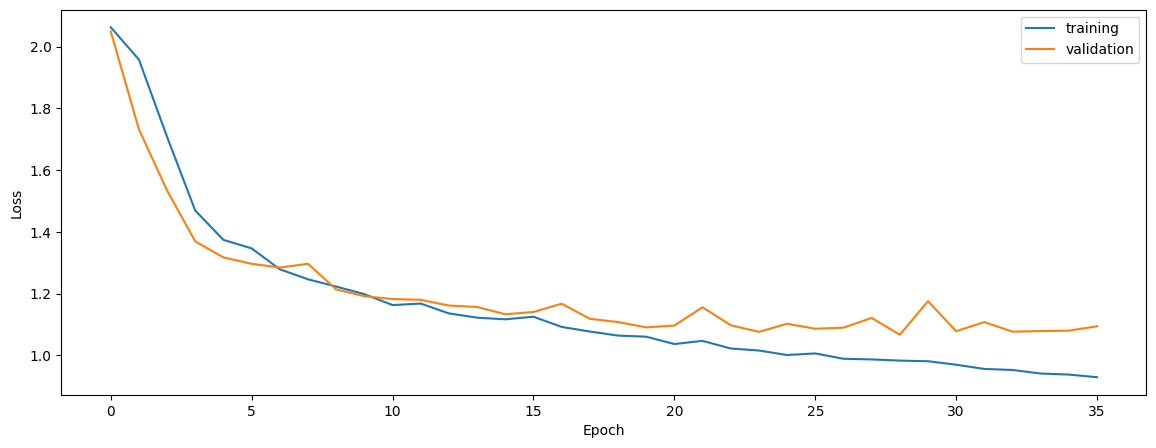

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.6245659266695567


0.5831969401995073


0.5667896037020285


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.5895246786827896


0.5796444707401033


0.5419593385977924


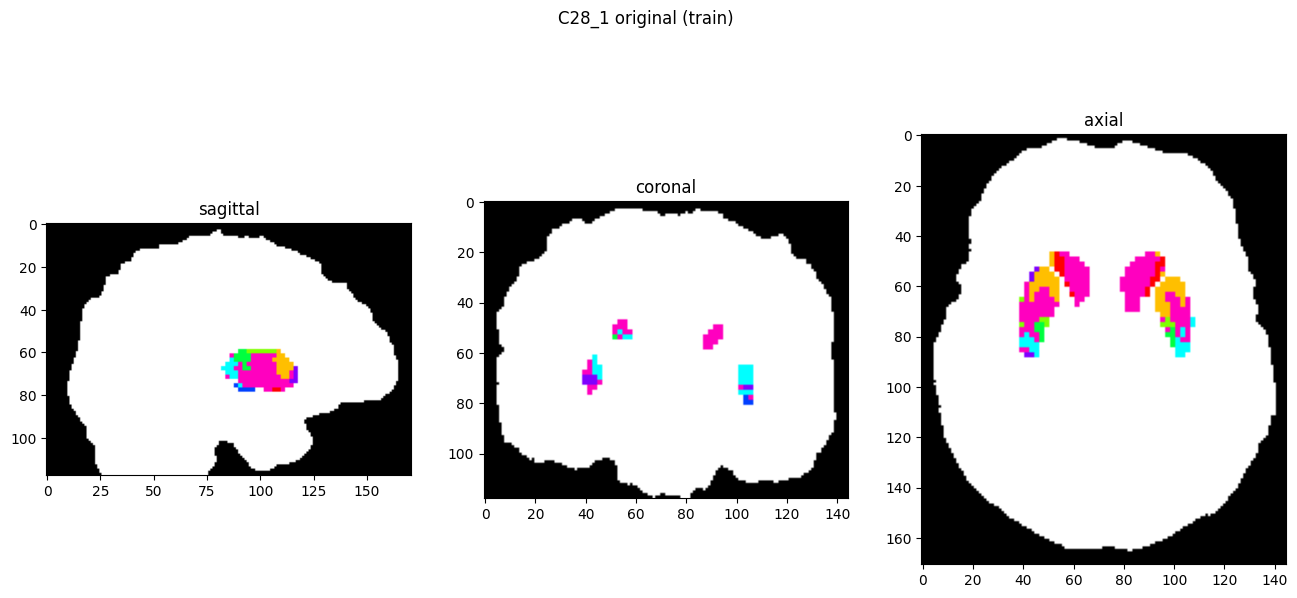

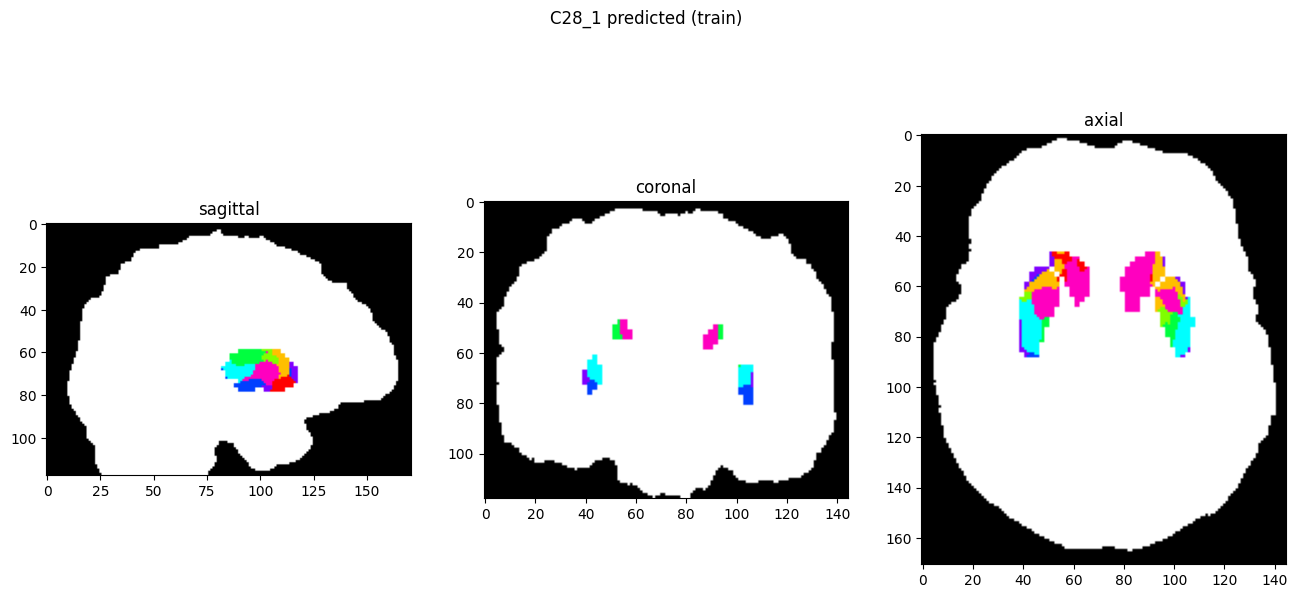

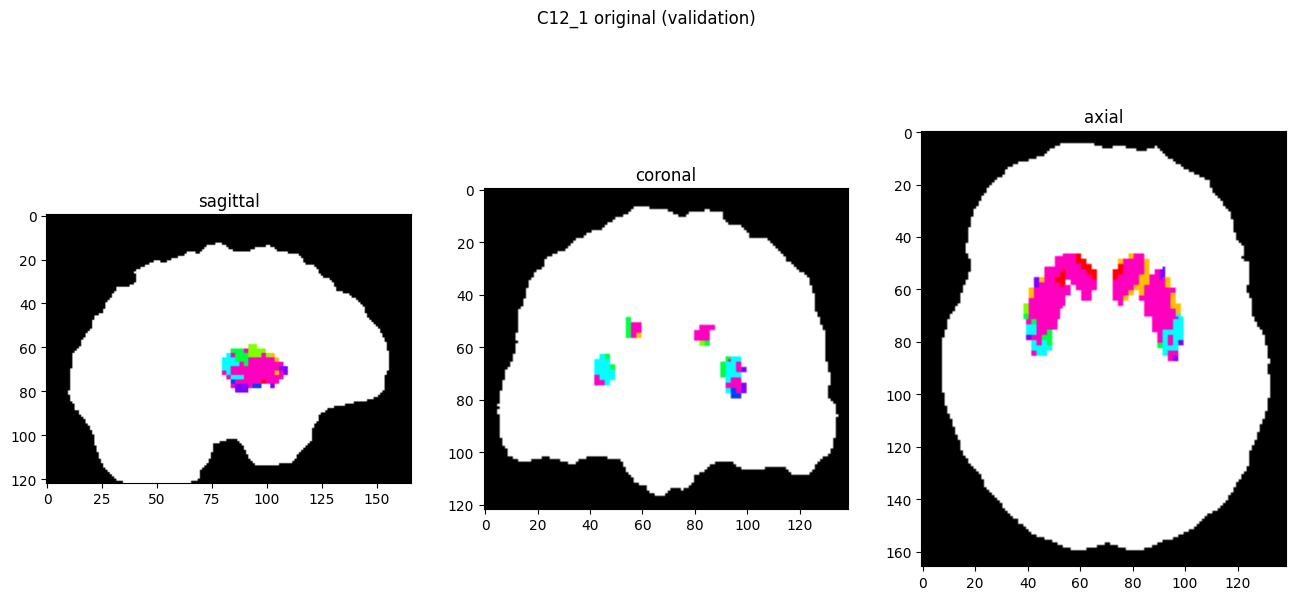

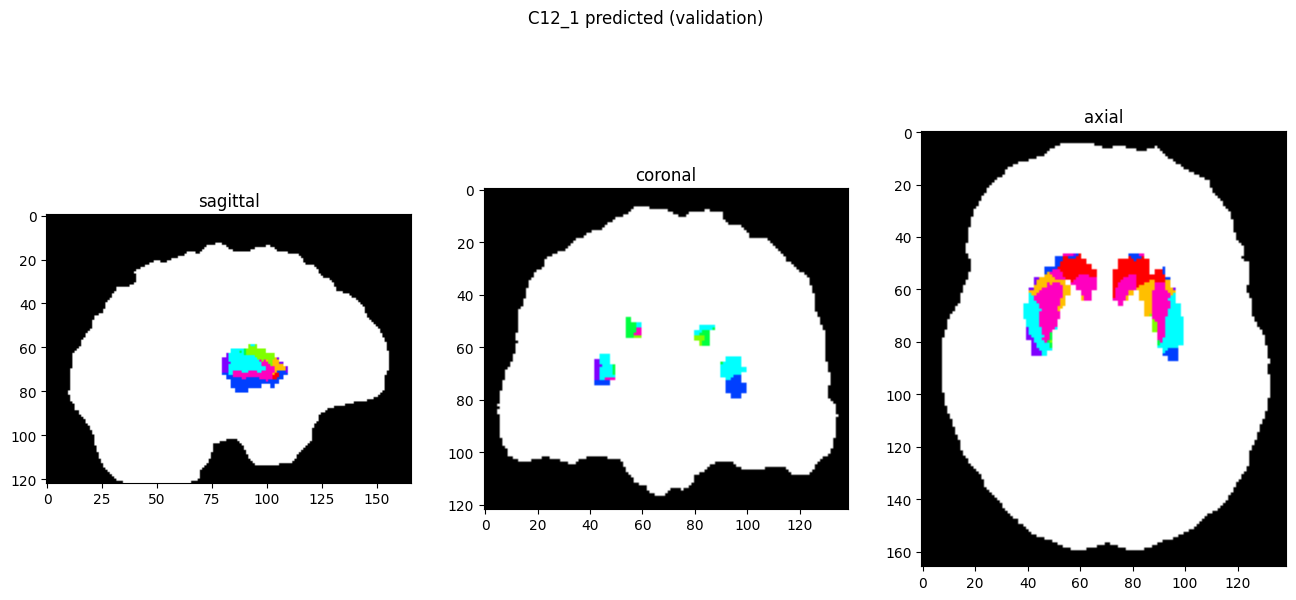

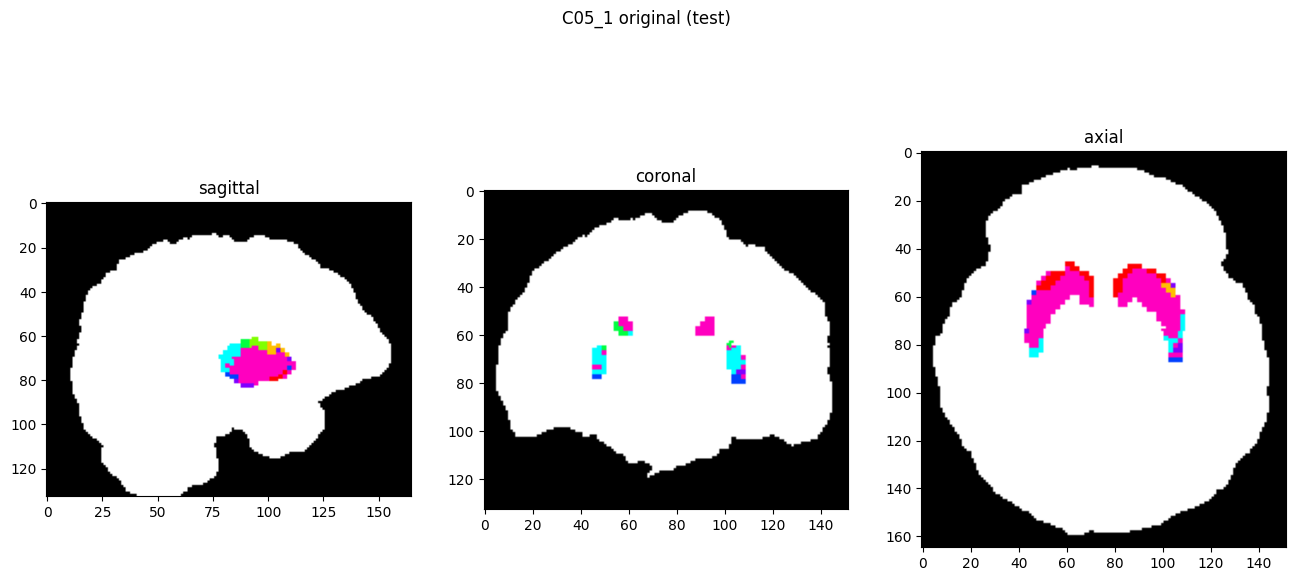

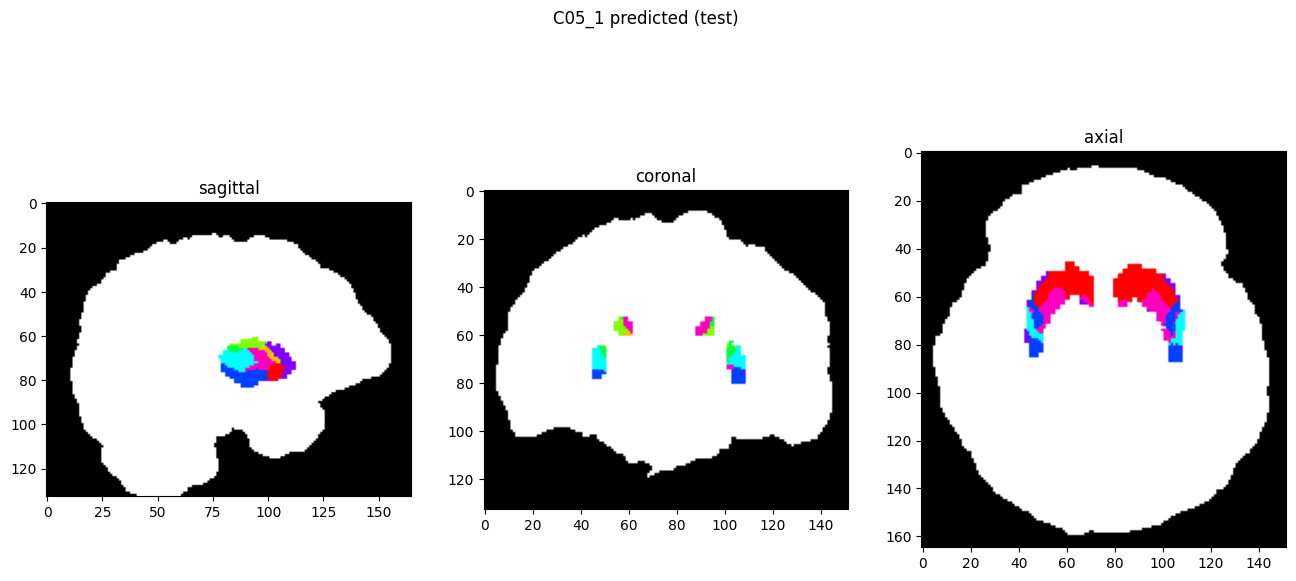

In [9]:
showResults(model, gen, threshold=0)